In [ ]:
%matplotlib inline
#import fleks,yt
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.cm import ScalarMappable
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
from scipy import stats
import numpy as np
import os
import re
#from utilities import get_ticks
from matplotlib import cm, ticker
from os import listdir
from os.path import isfile, join
import glob
from PIL import Image
from natsort import natsorted
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from scipy import interpolate
from matplotlib.ticker import LogFormatter 
from matplotlib.ticker import LogLocator, LogFormatterSciNotation 
import tecplot as tp
import matplotlib.pyplot as plt
import matplotlib.tri as tri
from tecplot.exception import *
from tecplot.constant import *
import pandas as pd
from scipy.interpolate import griddata
from operator import add
from scipy.ndimage import label
import pickle

In [ ]:
# Define Constants
amu = 1.67e-27
k_b = 1.38e-23
mu_0 = 1.257e-6
R_M = 2440e3 #m
m_p = 1.67e-27 # kg
e = 1.60218e-19 # C

# Define utility functions
def read_dataset(mypath):
    # Reads in file "mypath" and returns a dataset object. May take a while for larger files.

    print("reading:",mypath)
    # First connect to TecPlot
    tp.session.connect()

    # Configure layout
    tp.new_layout()
    dataset = tp.data.load_tecplot(mypath)
    frame = tp.active_frame()
    frame.plot_type = PlotType.Cartesian3D

    # Return dataset
    return dataset

def Bz_dip(x_array,y_array,z_array):
    return - 200.9 * (3*(z_array-0.2)**2 - (x_array**2+y_array**2+(z_array-0.2)**2))/((x_array**2+y_array**2+(z_array-0.2)**2)**(5/2))

def extract_line(plane,line_start,line_end,num_points=200):
    # Input: 2d slice of domain (cannot be xz plane) format as a dictionary (like output from extract_values_fast), 
    # and the endpoints of a line to extract data for
    # Output: dictionary with same keys as the plane, but for data along the line
    # Does not interpolate, just finds nearest points to the line
    
    # Define arrays for the line
    x_axis = np.linspace(line_start[0],line_end[0],num_points)
    y_axis = np.linspace(line_start[1],line_end[1],num_points)
    
    # Define empty arrays for each value stored in the plane dictionary
    out_dict = {}
    for key in plane.keys():
        out_dict[key]=np.zeros_like(x_axis)

    # Interpolate to points
    for key in plane.keys():
        out_dict[key] = griddata( (plane["X"].ravel(),plane["Y"].ravel()), plane[key].ravel(), (x_axis,y_axis))
    
    # For each point, find the closest cell and store the values in the out_dict
    #for i in range(num_points):
    #    idx = (np.abs(plane["X"][0,:] - x_axis[i])).argmin()
    #    idy = (np.abs(plane["Y"][:,0] - y_axis[i])).argmin()
    #    for key in plane.keys():
    #        out_dict[key][i] = (plane[key][idy,idx])
    
    return out_dict

def get_files(dir, key=".*cut_particle_region0_0.*"):
    # For a directory "dir", return a list of all files which match the regex expression "key"
    all_files = [f for f in listdir(dir) if isfile(join(dir, f))]
    files=[]
    for file in all_files:
        match = re.search(key,file)
        if match != None:
            files.append(file)
    files.sort()
    # Now give them the appropriate name for their time
    named_files = {}
    for i in range(len(files)):
        time = round(i*dt+start_time,3)
        named_files[time] = files[i]
    # Now cut the list down to files inside t_bound
    reduced_files = {}
    for time in list(named_files.keys())[int((t_bound[0]-start_time)/dt):int((t_bound[1]-start_time)/dt)]: #only loop over the times within t_bound
        reduced_files[time] = str(named_files[time])
    return reduced_files

def convert_to_plt(dir,files):
    # Hand it a directory with the dict of files in it, and it will convert them to .plt and save in dir
    for file in files:
        dataset=read_dataset(str(dir+files[file]))
        print("saving file:",str(dir+files[file][:-3]+"plt"))
        tp.data.save_tecplot_plt(str(dir+files[file][:-3]+"plt"))

def extract_current_surface(path,var_ls=["Bz"]):
    # First, read in the dataset with tecplot
    dataset = read_dataset(path)

    # Extract the coordinate axes
    x_axis = np.unique(dataset.variable("X").values(0).as_numpy_array())
    y_axis = np.unique(dataset.variable("Y").values(0).as_numpy_array())[1:-1]
    z_axis = np.unique(dataset.variable("Z").values(0).as_numpy_array())

    # Create an ordered zone
    rect_zone = dataset.add_ordered_zone('rect_zone',[len(x_axis),len(y_axis-2),len(z_axis)])

    # Create 3D coordinate meshgrids
    xxx,yyy,zzz = np.meshgrid(x_axis,y_axis,z_axis)

    # Assign coordinate values to the rect_zone using the meshgrids
    rect_zone.values('X')[:] = xxx.ravel()
    rect_zone.values('Y')[:] = yyy.ravel()
    rect_zone.values('Z')[:] = zzz.ravel()

    # Define a list of all the variable indices which will be extracted (doesnt work since we need commas)
    variable_ls = [3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30]

    # Compute current, if requested
    if ("Jx" in var_ls) or ("Jy" in var_ls) or ("Jz" in var_ls):
        print("Computing J = ∇xB")
        tp.data.operate.execute_equation(equation='{Jx} = (ddy({Bz}) - ddz({By}))/(1.2566*10**(-6))/2440000*10**(-9)',
            ignore_divide_by_zero=True)
        tp.data.operate.execute_equation(equation='{Jy} = (ddz({Bx}) - ddx({Bz}))/(1.2566*10**(-6))/2440000*10**(-9)',
            ignore_divide_by_zero=True)
        tp.data.operate.execute_equation(equation='{Jz} = (ddx({By}) - ddy({Bx}))/(1.2566*10**(-6))/2440000*10**(-9)',
            ignore_divide_by_zero=True)
        variable_ls = [3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33]

    # CURRENTLY UNUSED: PRESSURE GRADIENTS FOR EACH SPECIES
    '''
    if ("dpS1_dx" in var_ls):
        print("Computing ∇$p_i$")
        tp.data.operate.execute_equation(equation='{dpS1_dx} = (ddx({pxxS1}) + ddx({pyyS1}) + ddx({pzzS1}))/3/2440000',
        ignore_divide_by_zero=True)
        tp.data.operate.execute_equation(equation='{dpS1_dy} = (ddy({pxxS1}) + ddy({pyyS1}) + ddy({pzzS1}))/3/2440000',
            ignore_divide_by_zero=True)
        tp.data.operate.execute_equation(equation='{dpS1_dz} = (ddz({pxxS1}) + ddz({pyyS1}) + ddz({pzzS1}))/3/2440000',
            ignore_divide_by_zero=True)
        variable_ls = [3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36]

    if ("dpS0_dx" in var_ls):
        print("Computing ∇$p_e$")
        tp.data.operate.execute_equation(equation='{dpS0_dx} = (ddx({pxxS0}) + ddx({pyyS0}) + ddx({pzzS0}))/3/2440000',
        ignore_divide_by_zero=True)
        tp.data.operate.execute_equation(equation='{dpS0_dy} = (ddy({pxxS0}) + ddy({pyyS0}) + ddy({pzzS0}))/3/2440000',
            ignore_divide_by_zero=True)
        tp.data.operate.execute_equation(equation='{dpS0_dz} = (ddz({pxxS0}) + ddz({pyyS0}) + ddz({pzzS0}))/3/2440000',
            ignore_divide_by_zero=True)
        variable_ls = [3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36]
    '''
    # Total pressure gradient
    if ("dp_dx" in var_ls):
        print("Computing ∇$p$")
        tp.data.operate.execute_equation(equation='{dp_dx} = (ddx({pxxS1}+{pxxS0}+{pyyS1}+{pyyS0}+{pzzS1}+{pzzS0}))/3/2440000',
        ignore_divide_by_zero=True)
        tp.data.operate.execute_equation(equation='{dp_dy} = (ddy({pxxS1}+{pxxS0}+{pyyS1}+{pyyS0}+{pzzS1}+{pzzS0}))/3/2440000',
            ignore_divide_by_zero=True)
        tp.data.operate.execute_equation(equation='{dp_dz} = (ddz({pxxS1}+{pxxS0}+{pyyS1}+{pyyS0}+{pzzS1}+{pzzS0}))/3/2440000',
            ignore_divide_by_zero=True)

    if "-grad(p)" in var_ls: 
        print("Computing -grad(p)") # Computed in SI [Pa/m]
        tp.data.operate.execute_equation(equation='{gradp} = (ddx({pxxS0}+{pyyS0}+{pzzS0}+{pxxS1}+{pyyS1}+{pzzS1}))*10**(-9)/3/2440000',
        ignore_divide_by_zero=True)

    if "ram" in var_ls: 
        print("Computing ram pressure gradient") # Computed in SI [Pa/m]
        tp.data.operate.execute_equation(equation='{ram} = (ddx({rhoS0}*100*{uxS0}*{uxS0}+{rhoS1}*{uxS1}*{uxS1}))*1.67*10**(-27+6+6)/2440000',
        ignore_divide_by_zero=True)

    if ("-grad(B^2)" in var_ls):
        print("Computing ∇$B^2$") # Computed in SI (T^2/m)
        tp.data.operate.execute_equation(equation='{dB2_dx} = (ddx({Bx}*{Bx}+{By}*{By}+{Bz}*{Bz}))*10**(-18)/2440000',
            ignore_divide_by_zero=True)
        #tp.data.operate.execute_equation(equation='{dB2_dy} = (ddy({Bx}*{Bx}+{By}*{By}+{Bz}*{Bz}))*10**(-18)/2440000',
        #    ignore_divide_by_zero=True)
        #tp.data.operate.execute_equation(equation='{dB2_dz} = (ddz({Bx}*{Bx}+{By}*{By}+{Bz}*{Bz}))*10**(-18)/2440000',
        #    ignore_divide_by_zero=True)

    if ("dB_dx" in var_ls): # Compute magnetic strength gradient, in nT / m
        print("Computing ∇B")
        tp.data.operate.execute_equation(equation='{dB_dx} = (ddx(({Bx}*{Bx}+{By}*{By}+{Bz}*{Bz})**(0.5)))/2440000',
            ignore_divide_by_zero=True)
        tp.data.operate.execute_equation(equation='{dB_dy} = (ddy(({Bx}*{Bx}+{By}*{By}+{Bz}*{Bz})**(0.5)))/2440000',
            ignore_divide_by_zero=True)
        tp.data.operate.execute_equation(equation='{dB_dz} = (ddz(({Bx}*{Bx}+{By}*{By}+{Bz}*{Bz})**(0.5)))/2440000',
            ignore_divide_by_zero=True)

    print("Beginning interpolation...")
    # Interpolate onto rect_zone
    tp.data.operate.interpolate_linear(source_zones=[0],
        destination_zone=1,
        #variables=variable_ls,
        fill_value=0)

    # Calculate the plasma beta meshgrid
    beta_meshgrid = (2*mu_0*(rect_zone.values("pxxS0").as_numpy_array()+rect_zone.values("pyyS0").as_numpy_array()+rect_zone.values("pzzS0").as_numpy_array()+rect_zone.values("pxxS1").as_numpy_array()+
                            rect_zone.values("pyyS1").as_numpy_array()+rect_zone.values("pzzS1").as_numpy_array())*1e9/3/(rect_zone.values("Bx").as_numpy_array()**2+rect_zone.values("By").as_numpy_array()**2+rect_zone.values("Bz").as_numpy_array()**2)).reshape(xxx.shape)
    beta_meshgrid[np.isnan(beta_meshgrid)] = -1

    # Define dictionary to save results
    data = {"X":xxx[:,:,0],"Y":yyy[:,:,0]} #, "Z":np.zeros_like(xxx[:,:,0])}

    print("Interpolation complete, searching for max beta and saving data")
    
    # Interate through each x,y coord to find the max beta on that z-line and save the data
    for name in np.concatenate([["Z"],var_ls]):
        print("Extracting",name)
        data[name] = np.zeros_like(xxx[:,:,0])
        
        # Consider special cases of what to do with some var_ls options
        if name == "pi":
            var = (rect_zone.values("pxxS1").as_numpy_array()+rect_zone.values("pyyS1").as_numpy_array()+
                   rect_zone.values("pzzS1").as_numpy_array()).reshape(xxx.shape)/3
        elif name == "Bz1":
            var = (rect_zone.values("Bz").as_numpy_array() - 
                Bz_dip(rect_zone.values("X").as_numpy_array(),rect_zone.values("Y").as_numpy_array(),rect_zone.values("Z").as_numpy_array())).reshape(xxx.shape)
        elif name == "Ti": #eV
            var = ((rect_zone.values("pxxS1").as_numpy_array()+rect_zone.values("pyyS1").as_numpy_array()+
                   rect_zone.values("pzzS1").as_numpy_array())*1e-9/(rect_zone.values("rhoS1").as_numpy_array()*1e6)/k_b/3/11600).reshape(xxx.shape)
        elif name == "Te":#eV
            var = ((rect_zone.values("pxxS0").as_numpy_array()+rect_zone.values("pyyS0").as_numpy_array()+
                   rect_zone.values("pzzS0").as_numpy_array())*1e-9/(rect_zone.values("rhoS1").as_numpy_array()*1e6)/k_b/3/11600).reshape(xxx.shape)
        elif name == "-grad(p)": #N/m^3
            var = -1*(rect_zone.values("gradp").as_numpy_array()).reshape(xxx.shape)
        elif name == "ram": #N/m^3
            var = (rect_zone.values("ram").as_numpy_array()).reshape(xxx.shape)
        elif name == '-grad(B^2)': #N/m^3
            var = -1*(rect_zone.values("dB2_dx").as_numpy_array()/2/mu_0).reshape(xxx.shape)
        
        # In general, the var_ls name is just the same name as the primative variable
        else:
            var = rect_zone.values(name).as_numpy_array().reshape(xxx.shape)

        # Save the correct data for each name in var_ls
        for idy in range(len(yyy[:,0,0])):
            for idx in range(len(xxx[0,:,0])):
                # If any of the beta values in this column are -1 near the middle, that means we are at the inner edge of the bounding box
                if np.min(beta_meshgrid[idy,idx,len(z_axis)//4:-len(z_axis)//4]) == -1:
                    data[name][idy,idx] = 0
                else:
                    idz = np.argmax(beta_meshgrid[idy,idx,:])
                    data[name][idy,idx] = var[idy,idx,idz]

        # Trim off data close to planet, out of plane:
        #if name!="Z":
        #    data[name][np.where((data["Z"]>0.25) & (data["X"]**2+data["Y"]**2+data["Z"]**2<1.1**2))] = 0

    print("Complete!")
    return data

def average_data(data):
    # Input: a time-stamped dictionary of datasets. Returns two dictionaries: one of the average value across time, and one of the std
    avg_data = {}
    std_data = {}

    # Assign the var_ls variables to our output dictionaries, and fill them with zeros
    for name in list((data[list(data.keys())[0]]).keys()):
        avg_data[name] = np.zeros_like(data[(list(data.keys())[0])][name])
        std_data[name] = np.zeros_like(data[(list(data.keys())[0])][name])

    # Begin calculation by iterating by var_ls item
    for name in list(data[(list(data.keys())[0])].keys()):
        # Create an empty array to temporarily store all the values for computing statistics from
        # This has the same number of rows as the first element stored in the dicitonary, and has as many columns as times saved
        temp_array = np.zeros((len(data[list(data.keys())[0]][name]),len(list(data.keys()))))
        
        for i in range(len(list(data.keys()))):
            # For each time, we save to a column of temp_array
            temp_array[:,i] = data[list(data.keys())[i]][name]

        # Save to output arrays
        avg_data[name] = np.mean(temp_array,axis=1)
        std_data[name] = np.std(temp_array,axis=1)

    return avg_data,std_data

def compute_2D_time_avg(dir,files,var_ls):
    # Iterate over all the files, and compute the average value of var in each cell. Return the array.

    # Step through each file
    print("Beginning averaging...")
    avg={}
    for time in list(files.keys()): 
        print("Pulling data for time t =",time)
        file = str(files[time])

        # Get current sheet data
        data = extract_current_surface(dir+file,var_ls=var_ls)

        # Save to average
        for var in var_ls:
            if time == list(files.keys())[0]:
                avg[var] = data[var]
            else:
                avg[var] = data[var]+avg[var]
    print("Averaging complete!")
    for var in var_ls:
        avg[var] = avg[var]/len(list(files.keys()))
    # I've already written code which relies on the output being an array, not a dictionary of arrays, so this next bit is to support
    # backwards compatibility
    if len(var_ls)==1:
        return avg[var_ls[0]]
    else:
        return avg

def run(plot_preset,particle_type,var_ls=["Bz"],loc=[-1.25,0],test=False):
    # Convert from .dat to .plt if needed
    if convert_first:
        files = get_files(dir,key="3d\_fluid.*\.dat")
        convert_to_plt(dir,files)
    files = get_files(dir,key="3d\_fluid.*\.plt")

    if plot_preset == "timeseries":
        data = plot_timeseries(dir,files,var_ls=var_ls,loc=loc)
        return data

    if plot_preset == "Bz_avg":
        Bz_avg = compute_2D_time_avg(dir,files,["Bz"])
    if plot_preset == "rho_avg":
        rho_avg = compute_2D_time_avg(dir,files,["rhoS1"])
    #if plot_preset == "pi_avg":
    #    pi_avg = compute_2D_time_avg(dir,files,"pi")
    if plot_preset == "ux_avg":
        if particle_type=="ion":
            ux_avg = compute_2D_time_avg(dir,files,["uxS1"])
        elif particle_type == "electron":
            ux_avg = compute_2D_time_avg(dir,files,["uxS0"])
    if plot_preset == "df_tracker":
        df_dict = None # Set up empty dictionary for first step
        df_history = None
    #    avg_dict = compute_2D_time_avg(dir,files,["Te","uxS1","uyS1"])

    # Iterate through each file
    all_data = {}
    for time in list(files.keys()): 
        print("Plotting t =",time)
        file = str(files[time])
        
        # Plot according to plot_preset
        if plot_preset == "Bz1_zoom":
            all_data[time] = plot_Bz1_zoom(dir,file,time)

        elif plot_preset == "Bz_zoom":
            all_data[time] = plot_Bz_zoom(dir,file,time)

        if plot_preset == "Bz_avg":
            all_data[time] = plot_Bz_avg(dir,file,time,Bz_avg)

        if plot_preset == "rho_avg":
            all_data[time] = plot_rho_avg(dir,file,time,rho_avg)
            return #Just plot the time-averaged data once

        if plot_preset == "pi_avg":
            all_data[time] = plot_pi_avg(dir,file,time,pi_avg)
            return #Just plot the time-averaged data once
        
        if plot_preset == "ux_zoom":
            all_data[time] = plot_ux_zoom(dir,file,time,particle_type)

        if plot_preset == "ux_avg":
            all_data[time] = plot_ux_avg(dir,file,time,particle_type,ux_avg)

        elif plot_preset == "p_zoom":
            all_data[time] = plot_p_zoom(dir,file,time,particle_type)

        elif plot_preset == "temperature_anisotropy":
            all_data[time] = plot_temperature_anisotropy(dir,file,time,particle_type)

        elif plot_preset == "non_gyrotropy":
            all_data[time] = plot_non_gyrotropy(dir,file,time,particle_type)

        elif plot_preset == "grad_curvature":
            all_data[time] = plot_grad_curvature(dir,file,time,particle_type)

        elif plot_preset == "current_sheet":
            all_data[time] = plot_current_sheet(dir,file,time)

        elif plot_preset == "J_inrt":
            all_data[time] = plot_J_inrt(dir,file,time,particle_type)

        elif plot_preset == "df_tracker":
            df_dict, df_history = plot_df_tracker(dir,file,time,df_dict = df_dict,df_history = df_history)

        elif plot_preset == "along_line":
            all_data[time] = plot_along_line(dir,file,time,var_ls=var_ls,loc=loc)

        # Abort and return data if test mode
        if test:
            return all_data

    return df_history
    

In [9]:
# Plotting functions

def plot_Bz1_zoom(dir,file,time):
        fig, ax = plt.subplots(figsize=(12,9))
        
        # Load in dataset
        #dataset = read_dataset(dir+file)

        # Find current sheet
        data = extract_current_surface(dir+file,var_ls=["Bz"])

        # Unpack variables
        X = data["X"]
        Y = data["Y"]
        Z = data["Z"]
        Bz = data["Bz"]
    
        # Slice out current sheet
        #current_sheet = extract_values_fast(dataset,var_ls=["Bz"],origin=origin,normal=normal)

        # Compute perturbation field, from https://ccmc.gsfc.nasa.gov/static/files/Dipole.pdf
        Bz_dip = - 200.9 * (3*(Z-0.2)**2 - (X**2+Y**2+(Z-0.2)**2))/((X**2+Y**2+(Z-0.2)**2)**(5/2))

        # Plot
        inner = plt.Circle((0, 0), 0.8, color='black')
        outer = plt.Circle((0, 0), 1, color='grey')

        xlims = [-2.5,-0.5]
        ylims = [-1,1]
        vmin = -130
        vmax = 20
        nlevels = 31 
        levels = np.linspace(vmin, vmax, nlevels)
        cs_plot = ax.contourf(X, Y, (Bz-Bz_dip), levels=levels, cmap='rainbow')

        x_major_ticks = np.arange(xlims[0], xlims[1], 0.25)
        x_minor_ticks = np.arange(xlims[0], xlims[1], 0.05)
        y_major_ticks = np.arange(ylims[0], ylims[1], 0.25)
        y_minor_ticks = np.arange(ylims[0], ylims[1], 0.05)

        ax.set_xticks(x_major_ticks)
        ax.set_xticks(x_minor_ticks, minor=True)
        ax.set_yticks(y_major_ticks)
        ax.set_yticks(y_minor_ticks, minor=True)

        ax.grid(which='both')
        ax.grid(which='minor', alpha=0.2)
        ax.grid(which='major', alpha=0.5)
        
        #ticks = get_ticks(vmin, vmax)
        clb1 = fig.colorbar(cs_plot, ax=ax) 
        clb1.ax.tick_params(labelsize=8)
        clb1.ax.set_title('$B_{z1}$ [nT]',fontsize=12)
        ax.set_aspect(1) # you may also use am.imshow(..., aspect="auto") to restore the aspect ratio
        ax.set_xlabel("X [$R_M$]")
        ax.set_ylabel("Y [$R_M$]")
        ax.add_patch(outer)
        ax.add_patch(inner)
        ax.set_xlim(xlims)
        ax.set_ylim(ylims)
        ax.set_title(str("$B_z-B_{dip}$ in current sheet at t="+"%.2f"%round(time,2)+"s"))

        # Save
        fig.savefig(str(str(dir[:-1])+"_plots/"+plot_preset+"_"+"%.2f"%round(time,2)+'.png'),bbox_inches='tight')
        plt.close(fig)

        # Hand back data
        return data

def plot_Bz_zoom(dir,file,time):
        fig, ax = plt.subplots(figsize=(12,9))
        
        # Load in dataset
        #dataset = read_dataset(dir+file)

        # Find current sheet
        data = extract_current_surface(dir+file,var_ls=["Bz"])

        # Unpack variables
        X = data["X"]
        Y = data["Y"]
        Z = data["Z"]
        Bz = data["Bz"]

        # Plot
        inner = plt.Circle((0, 0), 0.8, color='black')
        outer = plt.Circle((0, 0), 1, color='grey')

        xlims = [-3.0,-0.5]
        ylims = [-1,1]
        vmin = -20
        vmax = 20
        nlevels = 31 
        levels = np.linspace(vmin, vmax, nlevels)
        cs_plot = ax.contourf(X, Y, (Bz), levels=levels, cmap='bwr',extend="both")

        x_major_ticks = np.arange(xlims[0], xlims[1], 0.25)
        x_minor_ticks = np.arange(xlims[0], xlims[1], 0.05)
        y_major_ticks = np.arange(ylims[0], ylims[1], 0.25)
        y_minor_ticks = np.arange(ylims[0], ylims[1], 0.05)

        ax.set_xticks(x_major_ticks)
        ax.set_xticks(x_minor_ticks, minor=True)
        ax.set_yticks(y_major_ticks)
        ax.set_yticks(y_minor_ticks, minor=True)

        ax.grid(which='both')
        ax.grid(which='minor', alpha=0.2)
        ax.grid(which='major', alpha=0.5)
        
        #ticks = get_ticks(vmin, vmax)
        clb1 = fig.colorbar(cs_plot, ax=ax) 
        clb1.ax.tick_params(labelsize=8)
        clb1.ax.set_title('$B_x$ [nT]',fontsize=12)
        ax.set_aspect(1) # you may also use am.imshow(..., aspect="auto") to restore the aspect ratio
        ax.set_xlabel("X [$R_M$]")
        ax.set_ylabel("Y [$R_M$]")
        ax.add_patch(outer)
        ax.add_patch(inner)
        ax.set_xlim(xlims)
        ax.set_ylim(ylims)
        ax.set_title(str("$B_x$ in current sheet at t="+"%.2f"%round(time,2)+"s"))

        # Save
        fig.savefig(str(str(dir[:-1])+"_plots/"+plot_preset+"_"+"%.2f"%round(time,2)+'.png'),bbox_inches='tight')
        plt.close(fig)

        # Hand back data
        return data

def plot_Bz_avg(dir,file,time,Bz_avg):
        fig, ax = plt.subplots(figsize=(12,9))
        

        # Find current sheet
        data = extract_current_surface(dir+file,var_ls=["Bz"])

        # Unpack variables
        X = data["X"]
        Y = data["Y"]
        Z = data["Z"]
        Bz = data["Bz"]

        # Plot
        inner = plt.Circle((0, 0), 0.8, color='black')
        outer = plt.Circle((0, 0), 1, color='grey')

        xlims = [-2.5,-0.5]
        ylims = [-1,1]
        vmin = -40
        vmax = 40
        nlevels = 31 
        levels = np.linspace(vmin, vmax, nlevels)
        cs_plot = ax.contourf(X, Y, (Bz-Bz_avg), levels=levels, cmap='bwr')

        x_major_ticks = np.arange(xlims[0], xlims[1], 0.25)
        x_minor_ticks = np.arange(xlims[0], xlims[1], 0.05)
        y_major_ticks = np.arange(ylims[0], ylims[1], 0.25)
        y_minor_ticks = np.arange(ylims[0], ylims[1], 0.05)

        ax.set_xticks(x_major_ticks)
        ax.set_xticks(x_minor_ticks, minor=True)
        ax.set_yticks(y_major_ticks)
        ax.set_yticks(y_minor_ticks, minor=True)

        ax.grid(which='both')
        ax.grid(which='minor', alpha=0.2)
        ax.grid(which='major', alpha=0.5)
        
        #ticks = get_ticks(vmin, vmax)
        clb1 = fig.colorbar(cs_plot, ax=ax) 
        clb1.ax.tick_params(labelsize=8)
        clb1.ax.set_title('$B_{z1}$ [nT]',fontsize=12)
        ax.set_aspect(1) # you may also use am.imshow(..., aspect="auto") to restore the aspect ratio
        ax.set_xlabel("X [$R_M$]")
        ax.set_ylabel("Y [$R_M$]")
        ax.add_patch(outer)
        ax.add_patch(inner)
        ax.set_xlim(xlims)
        ax.set_ylim(ylims)
        ax.set_title(str("$B_z-B_{z,avg}$ in current sheet at t="+"%.2f"%round(time,2)+"s"))

        # Save
        fig.savefig(str(str(dir[:-1])+"_plots/"+plot_preset+"_"+"%.2f"%round(time,2)+'.png'),bbox_inches='tight')
        plt.close(fig)

        # Hand back data
        return data

def plot_rho_avg(dir,file,time,rho_avg):
        fig, ax = plt.subplots(figsize=(12,9))

        # Find current sheet
        data = extract_current_surface(dir+file,var_ls=["rhoS1"])

        # Unpack variables
        X = data["X"]
        Y = data["Y"]
        Z = data["Z"]
        rho = data["rhoS1"]

        # Plot
        inner = plt.Circle((0, 0), 0.8, color='black')
        outer = plt.Circle((0, 0), 1, color='grey')

        xlims = [-2.5,-0.5]
        ylims = [-1,1]
        vmin = 0
        vmax = 10
        nlevels = 31 
        levels = np.linspace(vmin, vmax, nlevels)
        cs_plot = ax.contourf(X, Y, rho_avg, levels=levels, cmap='viridis')

        x_major_ticks = np.arange(xlims[0], xlims[1], 0.25)
        x_minor_ticks = np.arange(xlims[0], xlims[1], 0.05)
        y_major_ticks = np.arange(ylims[0], ylims[1], 0.25)
        y_minor_ticks = np.arange(ylims[0], ylims[1], 0.05)

        ax.set_xticks(x_major_ticks)
        ax.set_xticks(x_minor_ticks, minor=True)
        ax.set_yticks(y_major_ticks)
        ax.set_yticks(y_minor_ticks, minor=True)

        ax.grid(which='both')
        ax.grid(which='minor', alpha=0.2)
        ax.grid(which='major', alpha=0.5)
        
        #ticks = get_ticks(vmin, vmax)
        clb1 = fig.colorbar(cs_plot, ax=ax) 
        clb1.ax.tick_params(labelsize=8)
        clb1.ax.set_title('rho [amu/cc]',fontsize=12)
        ax.set_aspect(1) # you may also use am.imshow(..., aspect="auto") to restore the aspect ratio
        ax.set_xlabel("X [$R_M$]")
        ax.set_ylabel("Y [$R_M$]")
        ax.add_patch(outer)
        ax.add_patch(inner)
        ax.set_xlim(xlims)
        ax.set_ylim(ylims)
        ax.set_title(str("Average proton density in current sheet"))

        # Save
        fig.savefig(str(str(dir[:-1])+"_plots/"+plot_preset+"_"+"%.2f"%round(time,2)+'.png'),bbox_inches='tight')
        plt.close(fig)

        # Hand back data
        return data

def plot_pi_avg(dir,file,time,pi_avg):
        fig, ax = plt.subplots(figsize=(12,9))

        # Find current sheet
        data = extract_current_surface(dir+file,var_ls=["pxxS1"])

        # Unpack variables
        X = data["X"]
        Y = data["Y"]
        Z = data["Z"]
        rho = data["pxxS1"]

        # Plot
        inner = plt.Circle((0, 0), 0.8, color='black')
        outer = plt.Circle((0, 0), 1, color='grey')

        xlims = [-2.5,-0.5]
        ylims = [-1,1]
        vmin = 0.1
        vmax = 6
        nlevels = 31 
        levels = np.linspace(vmin, vmax, nlevels)
        cs_plot = ax.contourf(X, Y, pi_avg, levels=levels, cmap='viridis')

        x_major_ticks = np.arange(xlims[0], xlims[1], 0.25)
        x_minor_ticks = np.arange(xlims[0], xlims[1], 0.05)
        y_major_ticks = np.arange(ylims[0], ylims[1], 0.25)
        y_minor_ticks = np.arange(ylims[0], ylims[1], 0.05)

        ax.set_xticks(x_major_ticks)
        ax.set_xticks(x_minor_ticks, minor=True)
        ax.set_yticks(y_major_ticks)
        ax.set_yticks(y_minor_ticks, minor=True)

        ax.grid(which='both')
        ax.grid(which='minor', alpha=0.2)
        ax.grid(which='major', alpha=0.5)
        
        #ticks = get_ticks(vmin, vmax)
        clb1 = fig.colorbar(cs_plot, ax=ax) 
        clb1.ax.tick_params(labelsize=8)
        clb1.ax.set_title('$p_i$ [nPa]',fontsize=12)
        ax.set_aspect(1) # you may also use am.imshow(..., aspect="auto") to restore the aspect ratio
        ax.set_xlabel("X [$R_M$]")
        ax.set_ylabel("Y [$R_M$]")
        ax.add_patch(outer)
        ax.add_patch(inner)
        ax.set_xlim(xlims)
        ax.set_ylim(ylims)
        ax.set_title(str("Average proton pressure in current sheet"))

        # Save
        fig.savefig(str(str(dir[:-1])+"_plots/"+plot_preset+"_"+"%.2f"%round(time,2)+'.png'),bbox_inches='tight')
        plt.close(fig)

        # Hand back data
        return data

def plot_ux_zoom(dir,file,time,particle_type):
        fig, ax = plt.subplots(figsize=(12,9))
        
        # Load in dataset
        #dataset = read_dataset(dir+file)

        # Find current sheet
        if particle_type=="ion":
            data = extract_current_surface(dir+file,var_ls=["uxS1"])
            ux = data["uxS1"]
        elif particle_type=="electron":
            data = extract_current_surface(dir+file,var_ls=["uxS0"])
            ux = data["uxS0"]

        # Unpack variables
        X = data["X"]
        Y = data["Y"]
        Z = data["Z"]

        # Plot
        inner = plt.Circle((0, 0), np.sqrt(0.8**2-0.2**2), color='black')
        outer = plt.Circle((0, 0), np.sqrt(1-0.2**2), color='grey')

        xlims = [-2.5,-0.5]
        ylims = [-1,1]
        if particle_type=="ion":
            vmin=-1000
            vmax=1000
        if particle_type=="electron":
            vmin=-2000
            vmax=2000
        nlevels = 31 
        levels = np.linspace(vmin, vmax, nlevels)
        cs_plot = ax.contourf(X, Y, (ux), levels=levels, cmap='bwr',extend='both')

        x_major_ticks = np.arange(xlims[0], xlims[1], 0.25)
        x_minor_ticks = np.arange(xlims[0], xlims[1], 0.05)
        y_major_ticks = np.arange(ylims[0], ylims[1], 0.25)
        y_minor_ticks = np.arange(ylims[0], ylims[1], 0.05)

        ax.set_xticks(x_major_ticks)
        ax.set_xticks(x_minor_ticks, minor=True)
        ax.set_yticks(y_major_ticks)
        ax.set_yticks(y_minor_ticks, minor=True)

        ax.grid(which='both')
        ax.grid(which='minor', alpha=0.2)
        ax.grid(which='major', alpha=0.5)
        
        #ticks = get_ticks(vmin, vmax)
        clb1 = fig.colorbar(cs_plot, ax=ax) 
        clb1.ax.tick_params(labelsize=8)
        clb1.ax.set_title('$u_x$ [km/s]',fontsize=12)
        ax.set_aspect(1) # you may also use am.imshow(..., aspect="auto") to restore the aspect ratio
        ax.set_xlabel("X [$R_M$]")
        ax.set_ylabel("Y [$R_M$]")
        ax.add_patch(outer)
        ax.add_patch(inner)
        ax.set_xlim(xlims)
        ax.set_ylim(ylims)
        ax.set_title(str(particle_type+" velocity at t="+"%.2f"%round(time,2)+"s"))

        # Save
        fig.savefig(str(str(dir[:-1])+"_plots/"+particle_type+"_"+plot_preset+"_"+"%.2f"%round(time,2)+'.png'),bbox_inches='tight')
        plt.close(fig)

        # Hand back data
        return data

def plot_ux_avg(dir,file,time,particle_type,ux_avg):
        fig, ax = plt.subplots(figsize=(12,9))
        

        # Find current sheet
        if particle_type=="ion":
            data = extract_current_surface(dir+file,var_ls=["uxS1"])
            ux = data["uxS1"]
        elif particle_type=="electron":
            data = extract_current_surface(dir+file,var_ls=["uxS0"])
            ux = data["uxS0"]

        # Unpack variables
        X = data["X"]
        Y = data["Y"]
        Z = data["Z"]

        # Plot
        inner = plt.Circle((0, 0), 0.8, color='black')
        outer = plt.Circle((0, 0), 1, color='grey')

        xlims = [-2.5,-0.5]
        ylims = [-1,1]
        if particle_type == "ion":
            vmin = -1000
            vmax = 1000 
        else:
            vmin = -5000
            vmax = 5000
        nlevels = 31 
        levels = np.linspace(vmin, vmax, nlevels)
        cs_plot = ax.contourf(X, Y, (ux-ux_avg), levels=levels, cmap='bwr',extend="both")

        x_major_ticks = np.arange(xlims[0], xlims[1], 0.25)
        x_minor_ticks = np.arange(xlims[0], xlims[1], 0.05)
        y_major_ticks = np.arange(ylims[0], ylims[1], 0.25)
        y_minor_ticks = np.arange(ylims[0], ylims[1], 0.05)

        ax.set_xticks(x_major_ticks)
        ax.set_xticks(x_minor_ticks, minor=True)
        ax.set_yticks(y_major_ticks)
        ax.set_yticks(y_minor_ticks, minor=True)

        ax.grid(which='both')
        ax.grid(which='minor', alpha=0.2)
        ax.grid(which='major', alpha=0.5)
        
        #ticks = get_ticks(vmin, vmax)
        clb1 = fig.colorbar(cs_plot, ax=ax) 
        clb1.ax.tick_params(labelsize=8)
        clb1.ax.set_title('$u_x$ [km/s]',fontsize=12)
        ax.set_aspect(1) # you may also use am.imshow(..., aspect="auto") to restore the aspect ratio
        ax.set_xlabel("X [$R_M$]")
        ax.set_ylabel("Y [$R_M$]")
        ax.add_patch(outer)
        ax.add_patch(inner)
        ax.set_xlim(xlims)
        ax.set_ylim(ylims)
        ax.set_title(str("$u_x-u_{x,avg}$ for "+particle_type+"s in current sheet at t="+"%.2f"%round(time,2)+"s"))

        # Save
        fig.savefig(str(str(dir[:-1])+"_plots/"+particle_type+"_"+plot_preset+"_"+"%.2f"%round(time,2)+'.png'),bbox_inches='tight')
        plt.close(fig)

        # Hand back data
        return data

def plot_p_zoom(dir,file,time,particle_type):
        fig, ax = plt.subplots(figsize=(12,9))

        # Find current sheet
        if particle_type=="ion":
            data = extract_current_surface(dir+file,var_ls=["pxxS1","pyyS1","pzzS1"])
            p = data["pxxS1"]+data["pyyS1"]+data["pzzS1"]
        elif particle_type=="electron":
            data = extract_current_surface(dir+file,var_ls=["pxxS0","pyyS0","pzzS0"])
            p = data["pxxS0"]+data["pyyS0"]+data["pzzS0"]

        # Unpack variables
        X = data["X"]
        Y = data["Y"]

        # Plot
        inner = plt.Circle((0, 0), 0.8, color='black')
        outer = plt.Circle((0, 0), 1, color='grey')

        xlims = [-1.75,-0.75]
        ylims = [-0.5,0.5]
        vmin = -1
        vmax = 1.5
        nlevels = 41 
        levels = np.logspace(vmin, vmax, nlevels)
        cs_plot = ax.contourf(X, Y, p, levels=levels, norm=LogNorm(), cmap='viridis')

        x_major_ticks = np.arange(xlims[0], xlims[1], 0.25)
        x_minor_ticks = np.arange(xlims[0], xlims[1], 0.05)
        y_major_ticks = np.arange(ylims[0], ylims[1], 0.25)
        y_minor_ticks = np.arange(ylims[0], ylims[1], 0.05)

        ax.set_xticks(x_major_ticks)
        ax.set_xticks(x_minor_ticks, minor=True)
        ax.set_yticks(y_major_ticks)
        ax.set_yticks(y_minor_ticks, minor=True)

        ax.grid(which='both')
        ax.grid(which='minor', alpha=0.2)
        ax.grid(which='major', alpha=0.5)
        
        #ticks = get_ticks(vmin, vmax)
        clb1 = fig.colorbar(cs_plot, ax=ax,norm=LogNorm())  
        clb1.locator = LogLocator()
        clb1.formatter = LogFormatterSciNotation()   
        clb1.ax.set_title('$p$ [nPa]',fontsize=12)
        ax.set_aspect(1) # you may also use am.imshow(..., aspect="auto") to restore the aspect ratio
        ax.set_xlabel("X [$R_M$]")
        ax.set_ylabel("Y [$R_M$]")
        ax.add_patch(outer)
        ax.add_patch(inner)
        ax.set_xlim(xlims)
        ax.set_ylim(ylims)
        ax.set_title(str(particle_type+"pressure in current sheet at t="+"%.2f"%round(time,2)+"s"))

        # Save
        fig.savefig(str(str(dir[:-1])+"_plots/"+particle_type+"_"+plot_preset+"_"+"%.2f"%round(time,2)+'.png'),bbox_inches='tight')
        plt.close(fig)

        # Hand back data
        return data

def plot_temperature_anisotropy(dir,file,time,particle_type):
    
    fig, ax = plt.subplots(ncols=2,figsize=(17,6))

    # Find current sheet
    if particle_type=="ion":
        data = extract_current_surface(dir+file,var_ls=["Bx","By","Bz","Ex","Ey","Ez","pxxS1","pxyS1","pxzS1","pyyS1","pyzS1","pzzS1","rhoS1"])
        pxx = data["pxxS1"]
        pxy = data["pxyS1"]
        pxz = data["pxzS1"]
        pyy = data["pyyS1"]
        pyz = data["pyzS1"]
        pzz = data["pzzS1"]
        rho = data["rhoS1"] # its actually number density
    elif particle_type=="electron":
        data = extract_current_surface(dir+file,var_ls=["Bx","By","Bz","Ex","Ey","Ez","pxxS0","pxyS0","pxzS0","pyyS0","pyzS0","pzzS0","rhoS0"])
        pxx = data["pxxS0"]
        pxy = data["pxyS0"]
        pxz = data["pxzS0"]
        pyy = data["pyyS0"]
        pyz = data["pyzS0"]
        pzz = data["pzzS0"]
        rho = data["rhoS0"]*100 # 0.01amu/cc electrons is actually 1 electron/cc
    else:
        print("ERROR: invalid particle type!")

    # Extract field terms
    Bx = data["Bx"]
    By = data["By"]
    Bz = data["Bz"]
    Ex = data["Ex"]
    Ey = data["Ey"]
    Ez = data["Ez"]

    # Compute magnetic unit vector
    B_mag = np.sqrt(Bx**2+By**2+Bz**2)
    bx,by,bz = 1/B_mag * [Bx,By,Bz]

    # Compute magnetic field unit vectors: u,v,b. u is parallel to ExB direction. v = uxb. We already have b.
    # In the end, our new system will be perp1, perp2, para (u,v,b). See back page of space physics 2024 notebook for derivation, or photos from sep. 4, 2024
    # Compute u first, making sure to normalize
    ux,uy,uz = [Ey*Bz-Ez*By, Ez*Bx-Ex*Bz, Ex*By-Ey*Bx]
    ux,uy,uz = 1/np.sqrt(ux**2+uy**2+uz**2)*[ux,uy,uz]

    # Then compute v (already normalized):
    vx,vy,vz = [uy*bz-uz*by, uz*bx-ux*bz, ux*by-uy*bx]

    # We now compute the three diagonal pressure components, using e.g. P_para = b . p . b
    P11 = ux*(pxx*ux+pxy*uy+pxz*uz) + uy*(pxy*ux+pyy*uy+pyz*uz) + uz*(pxz*ux+pyz*uy+pzz*uz)
    P22 = vx*(pxx*vx+pxy*vy+pxz*vz) + vy*(pxy*vx+pyy*vy+pyz*vz) + vz*(pxz*vx+pyz*vy+pzz*vz)
    P33 = bx*(pxx*bx+pxy*by+pxz*bz) + by*(pxy*bx+pyy*by+pyz*bz) + bz*(pxz*bx+pyz*by+pzz*bz)

    # For now, we are interested in the difference parallel (Pzz) and perpendicular (Pxx and Pyy)
    # See Gurnett+Bhattacharjee "Introduction to Plasma Physics: Kinetic Theory and the Moment Equations" p151
    T_perp = (P11+P11)/2/rho/k_b * 1e-9/1e6/11600/1e3# convert from nPa and 1/cm^3
    T_para = (P33)/rho/k_b * 1e-9/1e6/11600/1e3 #[keV]

    # Plot
    xlims = [-3,-0.5]
    ylims = [-1,1]

    #levels = np.logspace(vmin, vmax, nlevels)
    levels = np.linspace(1,4)

    # Plot perp temperature
    cs1 = ax[0].contourf(data["X"],data["Y"],T_perp, cmap='plasma', levels=levels,extend="both")#,norm = LogNorm(),extend="both")

    x_major_ticks = np.arange(xlims[0], xlims[1], 0.25)
    x_minor_ticks = np.arange(xlims[0], xlims[1], 0.05)
    y_major_ticks = np.arange(ylims[0], ylims[1], 0.25)
    y_minor_ticks = np.arange(ylims[0], ylims[1], 0.05)

    ax[0].set_xticks(x_major_ticks)
    ax[0].set_xticks(x_minor_ticks, minor=True)
    ax[0].set_yticks(y_major_ticks)
    ax[0].set_yticks(y_minor_ticks, minor=True)

    ax[0].grid(which='both')
    ax[0].grid(which='minor', alpha=0.2)
    ax[0].grid(which='major', alpha=0.5)

    clb1 = fig.colorbar(cs1, ax=ax[0])#,norm=LogNorm())  
    #clb1.locator = LogLocator()
    #clb1.formatter = LogFormatterSciNotation()       
    clb1.ax.tick_params(labelsize=8)
    clb1.ax.set_title('$T_{perp}$ [keV]',fontsize=12)
    
    ax[0].set_aspect(1) # you may also use am.imshow(..., aspect="auto") to restore the aspect ratio
    ax[0].set_xlabel("X [$R_M$]")
    ax[0].set_ylabel("Y [$R_M$]")
    ax[0].add_patch(plt.Circle((0, 0), 1, color='grey'))
    ax[0].add_patch(plt.Circle((0, 0), 0.8, color='black'))
    ax[0].set_xlim(xlims)
    ax[0].set_ylim(ylims)
    ax[0].set_title(str("Perpendicular temperature at t ="+"%.2f"%round(time,2)+"s"+"\n Particle type: "+particle_type))

    # Plot para temperature
    cs2 = ax[1].contourf(data["X"],data["Y"],T_para, cmap='plasma',levels=levels,extend="both")#,norm = LogNorm())

    ax[1].set_xticks(x_major_ticks)
    ax[1].set_xticks(x_minor_ticks, minor=True)
    ax[1].set_yticks(y_major_ticks)
    ax[1].set_yticks(y_minor_ticks, minor=True)

    ax[1].grid(which='both')
    ax[1].grid(which='minor', alpha=0.2)
    ax[1].grid(which='major', alpha=0.5)
    
    clb2 = fig.colorbar(cs2, ax=ax[1])#,norm=LogNorm())  
    #clb2.locator = LogLocator()
    #clb2.formatter = LogFormatterSciNotation()       
    clb2.ax.tick_params(labelsize=8)
    clb2.ax.set_title('$T_{para}$ [keV]',fontsize=12)
    
    ax[1].set_aspect(1) # you may also use am.imshow(..., aspect="auto") to restore the aspect ratio
    ax[1].set_xlabel("X [$R_M$]")
    ax[1].set_ylabel("Y [$R_M$]")
    ax[1].add_patch(plt.Circle((0, 0), 1, color='grey'))
    ax[1].add_patch(plt.Circle((0, 0), 0.8, color='black'))
    ax[1].set_xlim(xlims)
    ax[1].set_ylim(ylims)
    ax[1].set_title(str("Parallel temperature at t ="+"%.2f"%round(time,2)+"s"+"\n Particle type: "+particle_type))

    # Save
    fig.savefig(str(str(dir[:-1])+"_plots/"+particle_type+"_"+plot_preset+"_"+"%.2f"%round(time,2)+'.png'),bbox_inches='tight')
    plt.close(fig)

    # Hand back data
    return data

def plot_non_gyrotropy(dir,file,time,particle_type):
    
    fig, ax = plt.subplots(ncols=2,figsize=(15,6))

    # Find current sheet
    if particle_type=="ion":
        data = extract_current_surface(dir+file,var_ls=["Bx","By","Bz","pxxS1","pxyS1","pxzS1","pyyS1","pyzS1","pzzS1"])
        Pxx = data["pxxS1"]
        Pxy = data["pxyS1"]
        Pxz = data["pxzS1"]
        Pyy = data["pyyS1"]
        Pyz = data["pyzS1"]
        Pzz = data["pzzS1"]
    elif particle_type=="electron":
        data = extract_current_surface(dir+file,var_ls=["Bx","By","Bz","pxxS0","pxyS0","pxzS0","pyyS0","pyzS0","pzzS0"])
        Pxx = data["pxxS0"]
        Pxy = data["pxyS0"]
        Pxz = data["pxzS0"]
        Pyy = data["pyyS0"]
        Pyz = data["pyzS0"]
        Pzz = data["pzzS0"]
    else:
        print("ERROR: invalid particle type!")

    # Extract field terms
    Bx = data["Bx"]
    By = data["By"]
    Bz = data["Bz"]

    # Compute magnetic unit vector
    B_mag = np.sqrt(Bx**2+By**2+Bz**2)
    bx,by,bz = 1/B_mag * [Bx,By,Bz]

    # APhi comes from Daughton (2008), and is most easily computed by first finding a number of N terms:
    Nxx = by*by*Pzz - 2*by*bz*Pyz + bz*bz*Pyy
    Nxy = -by*bx*Pzz + by*bz*Pxz + bz*bx*Pyz - bz*bz*Pxy
    Nxz = by*bx*Pyz - by*by*Pxz - bz*bx*Pyy + bz*by*Pxy
    Nyy = bx*bx*Pzz - 2*bx*bz*Pxz + bz*bz*Pxx
    Nyz = -bx*bx*Pyz + bx*by*Pxz + bz*bx*Pxy - bz*by*Pxx
    Nzz = bx*bx*Pyy - 2*bx*by*Pxy + by*by*Pxx
    alpha = Nxx+Nyy+Nzz
    beta = -(Nxy**2+Nxz**2+Nyz**2-Nxx*Nyy-Nxx*Nzz-Nyy*Nzz)
    APhi = 2*np.sqrt(alpha**2-4*beta)/alpha

    # Q comes from Swisdak (2016) and uses the parallel pressure as I've previous calculated it:
    P_para = bx**2*Pxx + by**2*Pyy + bz**2*Pzz + 2*(bx*by*Pxy + bx*bz*Pxz + by*bz*Pyz)
    I1 = Pxx+Pyy+Pzz
    I2 = Pxx*Pyy+Pxx*Pzz+Pyy*Pzz - (Pxy**2+Pxz**2+Pyz**2)
    Q = 1 - 4*I2/(I1-P_para)/(I1+3*P_para)
    
    # Plot
    xlims = [-2.5,-0.5]
    ylims = [-1,1]
    vmin = 0
    vmax = 2
    nlevels = 31 
    levels = np.linspace(vmin, vmax, nlevels)

    # Plot APhi
    cs1 = ax[0].contourf(data["X"],data["Y"],APhi, cmap='plasma', levels=levels)

    x_major_ticks = np.arange(xlims[0], xlims[1], 0.25)
    x_minor_ticks = np.arange(xlims[0], xlims[1], 0.05)
    y_major_ticks = np.arange(ylims[0], ylims[1], 0.25)
    y_minor_ticks = np.arange(ylims[0], ylims[1], 0.05)

    ax[0].set_xticks(x_major_ticks)
    ax[0].set_xticks(x_minor_ticks, minor=True)
    ax[0].set_yticks(y_major_ticks)
    ax[0].set_yticks(y_minor_ticks, minor=True)

    ax[0].grid(which='both')
    ax[0].grid(which='minor', alpha=0.2)
    ax[0].grid(which='major', alpha=0.5)

    clb1 = fig.colorbar(cs1, ax=ax[0])#,norm=LogNorm())  
    #clb1.locator = LogLocator()
    #clb1.formatter = LogFormatterSciNotation()       
    clb1.ax.tick_params(labelsize=8)
    clb1.ax.set_title('Aϕ',fontsize=12)
    
    ax[0].set_aspect(1) # you may also use am.imshow(..., aspect="auto") to restore the aspect ratio
    ax[0].set_xlabel("X [$R_M$]")
    ax[0].set_ylabel("Y [$R_M$]")
    ax[0].add_patch(plt.Circle((0, 0), 1, color='grey'))
    ax[0].add_patch(plt.Circle((0, 0), 0.8, color='black'))
    ax[0].set_xlim(xlims)
    ax[0].set_ylim(ylims)
    ax[0].set_title(str("Aϕ at t ="+"%.2f"%round(time,2)+"s"+"\n Particle type: "+particle_type))

    # Plot Q
    vmin = 0
    vmax = 1
    nlevels = 31 
    levels = np.linspace(vmin, vmax, nlevels)
    
    cs2 = ax[1].contourf(data["X"],data["Y"],np.sqrt(Q), cmap='plasma',levels = levels)#norm = LogNorm()

    ax[1].set_xticks(x_major_ticks)
    ax[1].set_xticks(x_minor_ticks, minor=True)
    ax[1].set_yticks(y_major_ticks)
    ax[1].set_yticks(y_minor_ticks, minor=True)

    ax[1].grid(which='both')
    ax[1].grid(which='minor', alpha=0.2)
    ax[1].grid(which='major', alpha=0.5)
    
    clb2 = fig.colorbar(cs2, ax=ax[1])#,norm=LogNorm())  
    #clb2.locator = LogLocator()
    #clb2.formatter = LogFormatterSciNotation()       
    clb2.ax.tick_params(labelsize=8)
    clb2.ax.set_title('$\sqrt{Q}$',fontsize=12)
    
    ax[1].set_aspect(1) # you may also use am.imshow(..., aspect="auto") to restore the aspect ratio
    ax[1].set_xlabel("X [$R_M$]")
    ax[1].set_ylabel("Y [$R_M$]")
    ax[1].add_patch(plt.Circle((0, 0), 1, color='grey'))
    ax[1].add_patch(plt.Circle((0, 0), 0.8, color='black'))
    ax[1].set_xlim(xlims)
    ax[1].set_ylim(ylims)
    ax[1].set_title(str("$\sqrt{Q}$ at t ="+"%.2f"%round(time,2)+"s"+"\n Particle type: "+particle_type))

    # Save
    fig.savefig(str(str(dir[:-1])+"_plots/"+particle_type+"_"+plot_preset+"_"+"%.2f"%round(time,2)+'.png'),bbox_inches='tight')
    plt.close(fig)

    # Hand back data
    return data

def plot_grad_curvature(dir,file,time,particle_type):
    
    fig, ax = plt.subplots(ncols=1,figsize=(8,6))

    # Find current sheet
    if particle_type=="ion":
        data = extract_current_surface(dir+file,var_ls=["Bx","By","Bz","Ex","Ey","Ez","pxxS1","pxyS1","pxzS1","pyyS1","pyzS1","pzzS1","rhoS1","dB_dx","dB_dy","dB_dz"])
        pxx = data["pxxS1"]
        pxy = data["pxyS1"]
        pxz = data["pxzS1"]
        pyy = data["pyyS1"]
        pyz = data["pyzS1"]
        pzz = data["pzzS1"]
        n = data["rhoS1"]*1e6 # number density in num / m^3
    elif particle_type=="electron":
        data = extract_current_surface(dir+file,var_ls=["Bx","By","Bz","Ex","Ey","Ez","pxxS0","pxyS0","pxzS0","pyyS0","pyzS0","pzzS0","rhoS0","dB_dx","dB_dy","dB_dz"])
        pxx = data["pxxS0"]
        pxy = data["pxyS0"]
        pxz = data["pxzS0"]
        pyy = data["pyyS0"]
        pyz = data["pyzS0"]
        pzz = data["pzzS0"]
        n = data["rhoS0"]*100*1e6 # 0.01amu/cc electrons is actually 1 electron/cc
    else:
        print("ERROR: invalid particle type!")

    # Unpack data
    X = data["X"]
    Y = data["X"]
    Z = data["X"]
    Bx = data["Bx"]
    By = data["By"]
    Bz = data["Bz"]
    dB_dx = data["dB_dx"]
    dB_dy = data["dB_dy"]
    dB_dz = data["dB_dz"]
    Ex = data["Ex"]
    Ey = data["Ey"]
    Ez = data["Ez"]

    # Compute perturbation field
    #Bz1 = Bz - Bz_dip(X,Y,Z)

    # Compute magnetic unit vector
    B_mag = np.sqrt(Bx**2+By**2+Bz**2) # nT
    bx,by,bz = 1/B_mag * [Bx,By,Bz]

    # Compute magnetic field unit vectors: u,v,b. u is parallel to ExB direction. v = uxb. We already have b.
    # In the end, our new system will be perp1, perp2, para (u,v,b). See back page of space physics 2024 notebook for derivation, or photos from sep. 4, 2024
    # Compute u first, making sure to normalize
    ux,uy,uz = [Ey*Bz-Ez*By, Ez*Bx-Ex*Bz, Ex*By-Ey*Bx]
    ux,uy,uz = 1/np.sqrt(ux**2+uy**2+uz**2)*[ux,uy,uz]

    # Then compute v (already normalized):
    vx,vy,vz = [uy*bz-uz*by, uz*bx-ux*bz, ux*by-uy*bx]

    # We now compute the three diagonal pressure components, using e.g. P_para = b . p . b
    P11 = ux*(pxx*ux+pxy*uy+pxz*uz) + uy*(pxy*ux+pyy*uy+pyz*uz) + uz*(pxz*ux+pyz*uy+pzz*uz)
    P22 = vx*(pxx*vx+pxy*vy+pxz*vz) + vy*(pxy*vx+pyy*vy+pyz*vz) + vz*(pxz*vx+pyz*vy+pzz*vz)
    P33 = bx*(pxx*bx+pxy*by+pxz*bz) + by*(pxy*bx+pyy*by+pyz*bz) + bz*(pxz*bx+pyz*by+pzz*bz)

    # For now, we are interested in the difference parallel (Pzz) and perpendicular (Pxx and Pyy)
    # See Gurnett+Bhattacharjee "Introduction to Plasma Physics: Kinetic Theory and the Moment Equations" p151
    T_perp = (P11+P11)/2/n/k_b * 1e-9 # convert from nPa and 1/cm^3
    T_para = (P33)/2/n/k_b * 1e-9 # [K]

    # Now, find the parallel / perpendicular thermal velocities
    if particle_type=="ion":
        m = m_p
        q = e
    elif particle_type=="electron":
        m = m_p/100 # Using the simulated electron mass
        q = -e
    v_perp_th = np.sqrt(8*k_b*T_perp/(np.pi*m)) #m/s
    v_para_th = np.sqrt(8*k_b*T_para/(np.pi*m)) #m/s

    # Finally, compute gc drift in km/s
    v_gc_x = m*(0.5*v_perp_th**2+v_para_th**2)/q*(By*dB_dz-Bz*dB_dy)/B_mag**3/1e-9 * 1e-3
    v_gc_y = m*(0.5*v_perp_th**2+v_para_th**2)/q*(Bz*dB_dx-Bx*dB_dz)/B_mag**3/1e-9 * 1e-3
    #v_gc_z = m_p*(0.5*v_perp_th**2+v_para_th**2)/q*(Bx*dB_dy-By*dB_dx)/B_mag**3/1e-9 * 1e-3

    # Plot
    xlims = [-2.5,-0.5]
    ylims = [-1,1]
    quiver_skip = 5
    if particle_type=="ion":
        vmin = 1
        vmax = 3.5
    elif particle_type=="electron":
        vmin = 6
        vmax = 8.5
    nlevels = 31 
    levels = np.logspace(vmin, vmax, nlevels)

    # Plot perp temperature
    contour_plot = ax.contourf(data["X"],data["Y"],
                               np.sqrt(v_gc_x**2+v_gc_y**2), cmap='viridis', levels=levels,norm = LogNorm())
    quiver_plot = ax.quiver(data["X"][::quiver_skip,::quiver_skip],data["Y"][::quiver_skip,::quiver_skip], 
                            v_gc_x[::quiver_skip,::quiver_skip], v_gc_y[::quiver_skip,::quiver_skip],color="white")

    x_major_ticks = np.arange(xlims[0], xlims[1], 0.25)
    x_minor_ticks = np.arange(xlims[0], xlims[1], 0.05)
    y_major_ticks = np.arange(ylims[0], ylims[1], 0.25)
    y_minor_ticks = np.arange(ylims[0], ylims[1], 0.05)

    ax.set_xticks(x_major_ticks)
    ax.set_xticks(x_minor_ticks, minor=True)
    ax.set_yticks(y_major_ticks)
    ax.set_yticks(y_minor_ticks, minor=True)

    ax.grid(which='both')
    ax.grid(which='minor', alpha=0.2)
    ax.grid(which='major', alpha=0.5)

    clb1 = fig.colorbar(contour_plot, ax=ax,norm=LogNorm())  
    clb1.locator = LogLocator()
    clb1.formatter = LogFormatterSciNotation()       
    clb1.ax.tick_params(labelsize=8)
    clb1.ax.set_title('$v_{GC}$ [km/s]',fontsize=12)
    
    ax.set_aspect(1) # you may also use am.imshow(..., aspect="auto") to restore the aspect ratio
    ax.set_xlabel("X [$R_M$]")
    ax.set_ylabel("Y [$R_M$]")
    ax.add_patch(plt.Circle((0, 0), 1, color='grey'))
    ax.add_patch(plt.Circle((0, 0), 0.8, color='black'))
    ax.set_xlim(xlims)
    ax.set_ylim(ylims)
    ax.set_title(str("Gradient-curvature drift velocity at t ="+"%.2f"%round(time,2)+"s"+"\n Particle type: "+particle_type))

    # Save
    fig.savefig(str(str(dir[:-1])+"_plots/"+particle_type+"_"+plot_preset+"_"+"%.2f"%round(time,2)+'.png'),bbox_inches='tight')
    plt.close(fig)

    # Hand back data
    return data

def plot_current_sheet(dir,file,time):
    fig, ax = plt.subplots(ncols=2,figsize=(16,5))
    
    # Load in dataset
    #dataset = read_dataset(dir+file)

    # Find current sheet
    data = extract_current_surface(dir+file,var_ls=["Bz"])

    # Unpack variables
    X = data["X"]
    Y = data["Y"]
    Z = data["Z"]
    Bz = data["Bz"]

    # Plot left view
    inner = plt.Circle((0, 0), 0.8, color='black')
    outer = plt.Circle((0, 0), 1, color='grey')

    xlims = [-3.5,-0.5]
    ylims = [-1,1]
    xz_plot = ax[0].scatter(X[::-1,::-1], Z[::-1,::-1], c = Y[::-1,::-1], vmin=-1,vmax=1, cmap='bwr',alpha=0.5)

    x_major_ticks = np.arange(xlims[0], xlims[1], 0.25)
    x_minor_ticks = np.arange(xlims[0], xlims[1], 0.05)
    y_major_ticks = np.arange(ylims[0], ylims[1], 0.25)
    y_minor_ticks = np.arange(ylims[0], ylims[1], 0.05)

    ax[0].set_xticks(x_major_ticks)
    ax[0].set_xticks(x_minor_ticks, minor=True)
    ax[0].set_yticks(y_major_ticks)
    ax[0].set_yticks(y_minor_ticks, minor=True)

    ax[0].grid(which='both')
    ax[0].grid(which='minor', alpha=0.2)
    ax[0].grid(which='major', alpha=0.5)
    
    #ticks = get_ticks(vmin, vmax)
    clb1 = fig.colorbar(xz_plot, ax=ax[0]) 
    clb1.ax.tick_params(labelsize=8)
    clb1.ax.set_title('$Y$ [$R_M$]',fontsize=12)
    ax[0].set_aspect(1) # you may also use am.imshow(..., aspect="auto") to restore the aspect ratio
    ax[0].set_xlabel("X [$R_M$]")
    ax[0].set_ylabel("Z [$R_M$]")
    ax[0].add_patch(outer)
    ax[0].add_patch(inner)
    ax[0].set_xlim(xlims)
    ax[0].set_ylim(ylims)
    ax[0].set_title(str("Current sheet in XZ plane at t="+"%.2f"%round(time,2)+"s"))

    # Plot right view
    inner = plt.Circle((0, 0), 0.8, color='black')
    outer = plt.Circle((0, 0), 1, color='grey')

    vmin = -0.5
    vmax = 0.5
    nlevels = 23 
    levels = np.linspace(vmin, vmax, nlevels)
    xy_plot = ax[1].contourf(X, Y, (Z-0.2), levels=levels, cmap='bwr')

    ax[1].set_xticks(x_major_ticks)
    ax[1].set_xticks(x_minor_ticks, minor=True)
    ax[1].set_yticks(y_major_ticks)
    ax[1].set_yticks(y_minor_ticks, minor=True)

    ax[1].grid(which='both')
    ax[1].grid(which='minor', alpha=0.2)
    ax[1].grid(which='major', alpha=0.5)
    
    #ticks = get_ticks(vmin, vmax)
    clb2 = fig.colorbar(xy_plot, ax=ax[1]) 
    clb2.ax.tick_params(labelsize=8)
    clb2.ax.set_title('$(Z-0.2)$ [$R_M$]',fontsize=12)
    ax[1].set_aspect(1) # you may also use am.imshow(..., aspect="auto") to restore the aspect ratio
    ax[1].set_xlabel("X [$R_M$]")
    ax[1].set_ylabel("Y [$R_M$]")
    ax[1].add_patch(outer)
    ax[1].add_patch(inner)
    ax[1].set_xlim(xlims)
    ax[1].set_ylim(ylims)
    ax[1].set_title(str("Current sheet in XY plane at t="+"%.2f"%round(time,2)+"s"))

    # Save
    fig.savefig(str(str(dir[:-1])+"_plots/"+plot_preset+"_"+"%.2f"%round(time,2)+'.png'),bbox_inches='tight')
    plt.close(fig)

    # Hand back data
    return data

def plot_J_inrt(dir,file,time,particle_type):
    
    fig, ax = plt.subplots(ncols=3,nrows=2,figsize=(25,13))

    # If this is the first time-step, then we cannot compute the derivative for J_inrt
    if time == t_bound[0]:
        print("first time step! Cannot compute derivative")
        return

    # Get files for later reference
    files = get_files(dir,key="3d\_fluid.*\.plt")

    # Slice out current sheet, get velocity data, and derivaties of total pressure
    data = extract_current_surface(dir+file,var_ls=["rhoS1","uxS1","uyS1","uzS1","Bx","By","Bz","Jx","Jy","Jz","dp_dx","dp_dy","dp_dz"])
    rho = data["rhoS1"] # amu/cc
    ux,uy,uz = (data["uxS1"],data["uyS1"],data["uzS1"]) # km/s
    dp_dx,dp_dy,dp_dz = (data["dp_dx"],data["dp_dy"],data["dp_dz"]) # nPa/m

    Bx,By,Bz = (data["Bx"],data["By"],data["Bz"]) #nT
    Jx,Jy,Jz = (data["Jx"],data["Jy"],data["Jz"]) #micro A/m^2
    B_mag = np.sqrt(Bx**2+By**2+Bz**2)

    # COmpute the grad_P current
    prefactor = 1/(B_mag*1e-9)**2 
    prefactor[np.isnan(prefactor)] = 0

    J_gradP_x = prefactor * (1e-18) * (By*dp_dz - Bz*dp_dy)
    J_gradP_y = prefactor * (1e-18) * (Bz*dp_dx - Bx*dp_dz)
    J_gradP_z = prefactor * (1e-18) * (Bx*dp_dy - By*dp_dx)

    # To compute time derivative , we will re-read in the previous time step using the present current sheet fit
    data_prev = extract_current_surface(dir+str(files[round(time-dt,3)]),var_ls=["uxS1","uyS1","uzS1"])
    ux_prev,uy_prev,uz_prev = (data_prev["uxS1"],data_prev["uyS1"],data_prev["uzS1"])
        
    dux_dt = (ux-ux_prev)/dt # km/s^2
    duy_dt = (uy-uy_prev)/dt
    duz_dt = (uz-uz_prev)/dt

    J_inrt_x = (rho*m_p) * prefactor * (By*duz_dt - Bz*duy_dt)
    J_inrt_y = (rho*m_p) * prefactor * (Bz*dux_dt - Bx*duz_dt)
    J_inrt_z = (rho*m_p) * prefactor * (Bx*duy_dt - By*dux_dt)

    xlims = [-2,-0.5]
    ylims = [-1,0.25]

    x_major_ticks = np.arange(xlims[0], xlims[1], 0.25)
    x_minor_ticks = np.arange(xlims[0], xlims[1], 0.05)
    y_major_ticks = np.arange(ylims[0], ylims[1], 0.25)
    y_minor_ticks = np.arange(ylims[0], ylims[1], 0.05)

    # J_inrt plot
    J_ls = [Jx,Jy,Jz]
    plot_ls = [J_inrt_x,J_inrt_y,J_inrt_z]
    vmin = -1.2
    vmax = 1.2
    nlevels = 31 
    levels = np.linspace(vmin, vmax, nlevels)
    
    for i in range(len(plot_ls)):
        inner = plt.Circle((0, 0), 0.8, color='black')
        outer = plt.Circle((0, 0), 1, color='grey')

        plot = ax[0,i].contourf(data['X'], data['Y'], (plot_ls[i]-J_ls[i])*1e6, levels=levels, cmap='bwr')

        # Show line
        ax[0,i].plot([loc[0][0],loc[1][0]],[loc[0][1],loc[1][1]],color="black",lw=1.5,alpha=0.5)
        
        #clb = fig.colorbar(plot, ax=ax[i])  
        #clb.ax.set_title(str("$J_{inrt,"+str(["x","y","z"][i])+"}$ [μA/m$^2$]"),fontsize=12)
    
        ax[0,i].set_aspect(1) # you may also use am.imshow(..., aspect="auto") to restore the aspect ratio
        ax[0,i].set_xlabel("X [$R_M$]")
        ax[0,i].set_ylabel("Y [$R_M$]")
        ax[0,i].add_patch(outer)
        ax[0,i].add_patch(inner)
        ax[0,i].set_xlim(xlims)
        ax[0,i].set_ylim(ylims)
        ax[0,i].set_xticks(x_major_ticks)
        ax[0,i].set_xticks(x_minor_ticks, minor=True)
        ax[0,i].set_yticks(y_major_ticks)
        ax[0,i].set_yticks(y_minor_ticks, minor=True)
        ax[0,i].grid(which='both')
        ax[0,i].grid(which='minor', alpha=0.2)
        ax[0,i].grid(which='major', alpha=0.5)
        ax[0,i].set_title(str("$J_{inrt,"+str(["x","y","z"][i])+"}-J_{"+str(["x","y","z"][i])+"}$ at t="+str(round(time,2))+"s"))

    fig.subplots_adjust(right=0.8)
    cbar1 = fig.colorbar(plot, ax=ax[0,:], shrink=0.8)
    cbar1.ax.set_title(str("$J$ [μA/m$^2$]"),fontsize=12)
    
    #J_gradP plot
    plot_ls = [J_gradP_x,J_gradP_y,J_gradP_z]
    vmin = -1.2
    vmax = 1.2
    nlevels = 31 
    levels = np.linspace(vmin, vmax, nlevels)
    
    for i in range(len(plot_ls)):
        inner = plt.Circle((0, 0), 0.8, color='black')
        outer = plt.Circle((0, 0), 1, color='grey')

        plot = ax[1,i].contourf(data['X'], data['Y'], (plot_ls[i] - J_ls[i])*1e6, levels=levels, cmap='bwr')
        ax[1,i].plot([loc[0][0],loc[1][0]],[loc[0][1],loc[1][1]],color="black",lw=1.5,alpha=0.5)
        
        #clb = fig.colorbar(plot, ax=ax[i])  
        #clb.ax.set_title(str("$J_{inrt,"+str(["x","y","z"][i])+"}$ [μA/m$^2$]"),fontsize=12)
    
        ax[1,i].set_aspect(1) # you may also use am.imshow(..., aspect="auto") to restore the aspect ratio
        ax[1,i].set_xlabel("X [$R_M$]")
        ax[1,i].set_ylabel("Y [$R_M$]")
        ax[1,i].add_patch(outer)
        ax[1,i].add_patch(inner)
        ax[1,i].set_xlim(xlims)
        ax[1,i].set_ylim(ylims)
        ax[1,i].set_xticks(x_major_ticks)
        ax[1,i].set_xticks(x_minor_ticks, minor=True)
        ax[1,i].set_yticks(y_major_ticks)
        ax[1,i].set_yticks(y_minor_ticks, minor=True)
        ax[1,i].grid(which='both')
        ax[1,i].grid(which='minor', alpha=0.2)
        ax[1,i].grid(which='major', alpha=0.5)
        ax[1,i].set_title(str("$J_{grad(P),"+str(["x","y","z"][i])+"}-J_{"+str(["x","y","z"][i])+"}$ at t="+str(round(time,2))+"s"))

    cbar2 = fig.colorbar(plot, ax=ax[1, :], shrink=0.8)
    cbar2.ax.set_title(str("$J$ [μA/m$^2$]"),fontsize=12)

    # Save
    fig.savefig(str(str(dir[:-1])+"_plots/"+plot_preset+"_"+"%.2f"%round(time,2)+'.png'),bbox_inches='tight')
    plt.close(fig)

    # Hand back data
    return data

def plot_df_tracker(dir,file,time, df_dict = None, df_history = None):#,avg_dict):
    
    fig, ax = plt.subplots(ncols=1,figsize=(12,10))

    # Find current sheet
    data = extract_current_surface(dir+file,var_ls=["Bz","uxS0","uyS0","Te"])

    # Unpack data
    X = data["X"]
    Y = data["Y"]
    Z = data["Z"]
    Bz = data["Bz"] - avg_dict["Bz"]
    ux = data["uxS0"] #- avg_dict["uxS1"]
    uy = data["uyS0"] #- avg_dict["uyS1"]
    Te = (data["Te"] - avg_dict["Te"])/1e3 # convert to keV
    #Jx = data["Jx"]
    #Jy = data["Jy"]


    # Compute DF metric
    Te[Te<0] = 0
    Bz[Bz<0] = 0
    metric = Bz*Te

    # Plot
    xlims = [-2,-0.5]
    ylims = [-1,0.25]

    x0 = np.min(X)
    y0 = np.min(Y)
    dx = 1/64

    # Trim data to this region
    xi_min = int((xlims[0]-x0)/dx)
    xi_max = int((xlims[1]-x0)/dx)
    yi_min = int((ylims[0]-y0)/dx)
    yi_max = int((ylims[1]-y0)/dx)
    
    X = X[yi_min:yi_max,xi_min:xi_max]
    Y = Y[yi_min:yi_max,xi_min:xi_max]
    ux = ux[yi_min:yi_max,xi_min:xi_max]
    uy = uy[yi_min:yi_max,xi_min:xi_max]
    metric = metric[yi_min:yi_max,xi_min:xi_max]

    # Plot metric and velocity
    cutoff=2 # keV nT
    skip = 4
    #cs1 = ax.contourf(X,Y,metric, cmap='viridis',extend="both",levels=np.linspace(0,9,21))#,norm = LogNorm(),extend="both")
    ax.contour(X,Y,metric,[cutoff])
    ax.quiver(X[metric>cutoff][::skip],Y[metric>cutoff][::skip],(ux)[metric>cutoff][::skip],(uy)[metric>cutoff][::skip],
              color="white", width = 0.002, headwidth = 2)
    
    # Code from UM GPT to label regions
    # Create boolean mask where Z exceeds z_0
    mask = metric > cutoff
    
    # Label connected regions
    structure = np.zeros((3, 3), dtype=bool)  # Structuring element
    structure[1,:] = True
    structure[:,1] = True # Use a + shaped mask
    labeled, num_features = label(mask, structure=structure)
    
    # Find all the DF regions in this time slice
    new_df_dict = {}
    count=1
    for feature_num in range(1, num_features + 1):
        region = (labeled == feature_num)
        # Remove regions that are too small
        if len(X[region])>10:
            new_df_dict[count] = (X[region], Y[region])
            count+=1

    print("Found",len(new_df_dict.keys()),"DFs at this time")
    #for key in new_df_dict.keys():
    #    print("New DF#"+str(key)+" is at:",new_df_dict[key][0][0],new_df_dict[key][1][0]," - ",new_df_dict[key][0][-1],new_df_dict[key][1][-1])

    # Compare to previous df_dict, if any, and relabel DFs for continuity

    if df_dict is not None and len(new_df_dict.keys())>0: # Only proceed with attempting to match DFs if we have data from last timestep and there is at least 1 DF in this timestep
        # The name of the game is just to relabel all the keys appropriately.
        # Set up a new dictionary where we will make all these changes.
        next_df_dict = {}

        # Iterate through new_key_dict, which has all the dfs identified in this step (with keys which will generally be totally wrong)
        new_keys = list(new_df_dict.keys()).copy()
        overlap_masks = [] # Here, we will store key pairs: [new_key, old_key, agreement_lvl]
        for new_key in new_keys:
            for old_key in df_dict.keys():
                # Compare all the currently identified DFs to those from the previous step, and save an entry to overlap_masks if any overlap
                xmask = np.isin(new_df_dict[new_key][0],df_dict[old_key][0])
                ymask = np.isin(new_df_dict[new_key][1],df_dict[old_key][1])
                mask=xmask&ymask
                if mask.any():
                    print("New DF#"+str(new_key)+" overlaps with old DF#"+str(old_key))
                    overlap_masks.append([new_key,old_key,sum(mask)]) # sum(mask) gives the number of "True" in the list
        # Matrix stores the relationship between the DFs labelled at this time and the previous time.
        unfiltered_matrix = np.array(overlap_masks)#, shape=(len(overlap_masks),3))
        # If a new DF has appeared, we have no accounted for it yet (since it will have no overlap with the previous step).
        for key in new_keys:
            if key not in unfiltered_matrix[:,0]:
                unfiltered_matrix = np.vstack([unfiltered_matrix, [key,-1,0]]) # Add newly formed DFs to the register, and associate it with the previous DF -1 (i.e. assocaited with none)
        unfiltered_matrix = unfiltered_matrix[unfiltered_matrix[:,2].argsort()[::-1]] # Sort to start with largest overlap ones
        
        # We now need to remove repeated rows with repeated values of new_key (column zero) to stop an infinite cascade of new DFs
        # Now that we've sorted the data, the dfs with the most overlap will be selected for
        # Code to do this from umgpt
        def remove_duplicate_rows(arr):
            seen = set()
            filtered_rows = []
            for row in arr:
                if row[0] not in seen:
                    filtered_rows.append(row)
                    seen.add(row[0])
            return np.array(filtered_rows)

        # Only need to filter out rows if there are more rows in matrix than the number of dfs at this time
        if len(unfiltered_matrix[:,0])>len(new_df_dict.keys()):
            matrix = remove_duplicate_rows(unfiltered_matrix)
        else:
            matrix = unfiltered_matrix
        
        print("NEW DF KEY   OLD DF KEY   MATCH")
        print(matrix)

        temp_key=-1

        for i in range(len(matrix[:,0])):
            if matrix[i,1]==-1: # this means its a newly formed DF in this step.
                print("DF#"+str(matrix[i,0]),"is a new one and is temporarily assigned #"+str(temp_key))
                next_df_dict[temp_key] = new_df_dict[matrix[i,0]] # Give it a temporary name, we will come back to it at the end
                temp_key-=1
            elif (matrix[i,1] not in next_df_dict.keys()): # Check to see if this DF has already been named for the updated dict. If its not there, add it
                print("DF#"+str(matrix[i,1])+" has been tracked from the previous step")
                next_df_dict[matrix[i,1]] = new_df_dict[matrix[i,0]] # The name of the DF is taken from df_dict, and is populated with data from the new dict. The matrix is used as a reference to connect the two.
            else: # This means this DF has already been identified with a previous DF that has more overlap with it i.e. it is a child
                print("DF#"+str(matrix[i,1])+" has split and formed a new DF, which is temporarily assigned #"+str(temp_key))
                next_df_dict[temp_key] = new_df_dict[matrix[i,0]] # Give it a temporary name, we will come back to it at the end
                temp_key-=1
        # All DFs identified in this step have been assigned names in next_df_dict. Now, we need to rename the negative ones to the next largest names
        new_df_key = np.max(list(df_history.keys()))+1 # Start naming at one larger than the maximum df number already used
        for key in list(next_df_dict.keys()).copy():
            if key<0:
                print("Reassigning the temporary DF#"+str(key),"to DF#"+str(new_df_key))
                next_df_dict[new_df_key] = next_df_dict.pop(key)
                new_df_key+=1
        print("Feature tracking complete!")
        df_dict = next_df_dict   
    else:
        df_dict = new_df_dict    

    # Show the regions
    color_ls = ["tab:blue","tab:green","tab:blue","tab:orange","tab:purple","tab:brown","tab:pink","tab:gray","tab:olive","tab:cyan"]
    for key in df_dict.keys():
        X_region, Y_region = df_dict[key]
        ax.plot(X_region, Y_region, 'o', alpha=0.7, color = color_ls[key%10], label=str('DF '+str(key)))

    # Compute avg bulk parameters of DFs: X,Y,Z,density,flux,Ti,Te, ux and uy
    if df_history == None:
        df_history = {} # Setup empty dictionary if no data been saved
        
    # For each DF, either create a new item to store info about it or add to an existing item
    for key in df_dict.keys():
        if key not in df_history.keys(): # Create new dataframe if this df has not been registered already
            df_history[key] = pd.DataFrame(columns=['time','X','Y','Z','Bz','Te','ux','uy',"Jx","Jy",'area'])
        new_row = np.zeros(11)
        # Now we iterate over each coordinate associated with this DF
        for i in range(len(df_dict[key][0])):
            coord = [df_dict[key][0][i],df_dict[key][1][i]] # Remember, each item in df_dict is a tuple of the X coords and Y coords
            # Find which indices of "data" these coordinates correspond to
            ix = np.where(X[0,:]==coord[0])[0]
            iy = np.where(Y[:,1]==coord[1])[0]
            new_row[1] = new_row[1] + X[iy,ix]
            new_row[2] = new_row[2] + Y[iy,ix]
            new_row[3] = new_row[3] + Z[iy,ix]
            new_row[4] = new_row[4] + Bz[iy,ix]
            new_row[5] = new_row[5] + Te[iy,ix]
            new_row[6] = new_row[6] + ux[iy,ix]
            new_row[7] = new_row[7] + uy[iy,ix]
            new_row[8] = new_row[8] #+ Jx[iy,ix]
            new_row[9] = new_row[9] #+ Jy[iy,ix]
            
        # Divide by the total number of cells for this DF to get the average quantity
        new_row = new_row/(i+1) 
        new_row[0] = time # Set the first row to the time
        new_row[-1] = (1/64)**2*(i+1) # Set the last row to the area
        temp = df_history[key]
        temp.loc[len(temp)] = new_row
        df_history[key] = temp # Add this new row to the correct dataframe

        # Show a trace of each current DF's path
        ax.plot(temp["X"],temp["Y"], color = color_ls[key%10])

    x_major_ticks = np.arange(xlims[0], xlims[1], 0.25)
    x_minor_ticks = np.arange(xlims[0], xlims[1], 0.05)
    y_major_ticks = np.arange(ylims[0], ylims[1], 0.25)
    y_minor_ticks = np.arange(ylims[0], ylims[1], 0.05)

    ax.set_xticks(x_major_ticks)
    ax.set_xticks(x_minor_ticks, minor=True)
    ax.set_yticks(y_major_ticks)
    ax.set_yticks(y_minor_ticks, minor=True)

    ax.grid(which='both')
    ax.grid(which='minor', alpha=0.2)
    ax.grid(which='major', alpha=0.5)

    #clb1 = fig.colorbar(cs1, ax=ax)#,norm=LogNorm())  
    #clb1.locator = LogLocator()
    #clb1.formatter = LogFormatterSciNotation()       
    #clb1.ax.tick_params(labelsize=8)
    #clb1.ax.set_title('DF score [nT x keV]',fontsize=12)
    
    ax.set_aspect(1) # you may also use am.imshow(..., aspect="auto") to restore the aspect ratio
    ax.set_xlabel("X [$R_M$]")
    ax.set_ylabel("Y [$R_M$]")
    ax.add_patch(plt.Circle((0, 0), np.sqrt(1-0.2**2), color='grey'))
    ax.add_patch(plt.Circle((0, 0), np.sqrt(0.8**2-0.2**2), color='black'))
    #ax.set_xlim(xlims)
    #ax.set_ylim(ylims)
    ax.set_title(str("DF metric at t ="+"%.2f"%round(time,2)+"s"))
    ax.legend(loc='upper right')

    # Save
    fig.savefig(str(str(dir[:-1])+"_plots/"+plot_preset+"_"+"%.2f"%round(time,2)+'.png'),bbox_inches='tight')
    plt.close(fig)

    # Hand back data
    # df_dict is a dictionary of DFs in this time step (no history). The key is the name/number of the DF, and the item a list of X and Y coords
    return df_dict, df_history

def plot_timeseries(dir,files,var_ls=["Bz"],loc=[-1.25,0]):
    # Steps through all the files, pulling the requested data at loc to plot a timeseries
    
    # Declare a dictionary to save all the data as we gather it
    time_data = {"t":list(files.keys())}
    
    # Save a list for each variable, which is as long as the number of files to be read (i.e. number of timesteps)
    for var in var_ls:
        time_data[var] = np.zeros(len(list(files.keys())))
    
    # Step through each file, saving the data
    it = 0
    for time in list(files.keys()): 

        # Read in dataset
        print("Pulling data for time",time,"from file",files[time])
        dataset = read_dataset(dir+files[time])

        # Compute any extra variables
        if "Jx" in var_ls:
            tp.data.operate.execute_equation(equation='{Jx} = (ddy({Bz}) - ddz({By}))/(1.2566*10**(-6))/2440000*10**(-9)*1e6',
                ignore_divide_by_zero=True) # CONVERTED TO uA ALREADY
        elif "Jy" in var_ls:
            tp.data.operate.execute_equation(equation='{Jy} = (ddz({Bx}) - ddx({Bz}))/(1.2566*10**(-6))/2440000*10**(-9)*1e6',
                ignore_divide_by_zero=True)
        elif "Jz" in var_ls:
            tp.data.operate.execute_equation(equation='{Jz} = (ddx({By}) - ddy({Bx}))/(1.2566*10**(-6))/2440000*10**(-9)*1e6',
                ignore_divide_by_zero=True)

        # To find the current sheet, we need to find the max beta along the xy line of interest
        # Borrowing some code from PC_plotting/find_current_surface
        z_axis = np.unique(dataset.variable("Z").values(0).as_numpy_array())
        x_axis = np.zeros(len(z_axis))+loc[0]
        y_axis = np.zeros(len(z_axis))+loc[1]
        line = tp.data.extract.extract_line(zip(x_axis,y_axis,z_axis))

        # Compute beta along the line
        beta = (2*mu_0*(line.values("pxxS0").as_numpy_array()+line.values("pyyS0").as_numpy_array()+
                        line.values("pzzS0").as_numpy_array()+line.values("pxxS1").as_numpy_array()+
                        line.values("pyyS1").as_numpy_array()+
                        line.values("pzzS1").as_numpy_array())*1e9/3/(line.values("Bx").as_numpy_array()**2+
                        line.values("By").as_numpy_array()**2+line.values("Bz").as_numpy_array()**2))

        # Find index of max beta, corresponding to z coord of current sheet
        idz = np.argmax(beta)
        print("found current sheet at",line.values("X").as_numpy_array()[idz],line.values("Y").as_numpy_array()[idz],line.values("Z").as_numpy_array()[idz])

        # Save the necessary data to time_data, many are special cases
        for var in var_ls:
            if var=="p_ion":
                time_data[var][it] = (line.values("pxxS1").as_numpy_array()[idz]+line.values("pyyS1").as_numpy_array()[idz]+line.values("pzzS1").as_numpy_array()[idz])/3
            else:
                time_data[var][it] = line.values(var).as_numpy_array()[idz]
                
        
        it+=1

    # Plot the results
    fig, axs = plt.subplots(ncols=1,nrows=len(var_ls),figsize=(16,4*len(var_ls)))

    # Step through each subplot
    for i in range(len(axs)):

        axs[i].plot(time_data["t"],time_data[var_ls[i]])
        
        # Magnetic field plotting
        if (var_ls[i] == "Bx") or (var_ls[i] == "By") or (var_ls[i] == "Bz"):
            axs[i].plot(time_data["t"],time_data[var_ls[i]])
            axs[i].set_ylabel(str("$B_"+str(var_ls[i][-1])+"$ [nT]"))
        
        # Pressure plotting
        elif (var_ls[i] == "p_ion") or (var_ls[i] == "p_electron"):
            axs[i].set_ylabel(str("$p_{"+str(var_ls[i][2:])+"}$ [nPa]"))

        # Ion velocity plotting
        elif (var_ls[i] == "uxS1") or (var_ls[i] == "uyS1") or (var_ls[i] == "uzS1"):
            axs[i].set_ylabel(str("$u_{"+str(var_ls[i][1])+",ion}$ [km/s]"))

        # Electron velocity plotting
        elif (var_ls[i] == "uxS0") or (var_ls[i] == "uyS0") or (var_ls[i] == "uzS0"):
            axs[i].set_ylabel(str("$u_{"+str(var_ls[i][1])+",electron}$ [km/s]"))

        # Current plotting
        elif (var_ls[i] == "Jx") or (var_ls[i] == "Jy") or (var_ls[i] == "Jz"):
            axs[i].set_ylabel(str("$J_{"+str(var_ls[i][1])+"}$ [μA/m$^2$]"))

        axs[i].set_xlabel("Time [s]")

    fig.savefig(str(str(dir[:-1])+"_plots/"+plot_preset+'.png'),bbox_inches='tight')
    plt.close(fig)

    # Hand back data
    return time_data

def plot_along_line(dir,file,time,var_ls=["Bz"],loc=[[-1.5,-0.06],[-1.1,-0.06]],width=0.1,line_num=1):
    # Plot all the variables in var_ls along a line segment given by loc
    #loc should be format as [[x_start,y_start], [x_end,y_end]]
    # Optionally, if line_num!=1, then we pull data from multiple (line_num) lines which span a y extent of width
    
    # Load in dataset
    data = extract_current_surface(dir+file,var_ls=var_ls)

    num_points = 200

    # Cast data onto a line
    if line_num>1:
        dw = width/(line_num-1)
        lines = np.zeros((num_points,line_num))
        for line_i in range(line_num):
            lines[:,line_i] = extract_line(data,loc[0]+[0,-width/2+dw*line_i],loc[1]+[0,-width/2+dw*line_i],num_points = num_points)
        line = np.mean(lines,axis=1)
        line_
        
    else:
        line = extract_line(data,loc[0],loc[1])
        line["r"] = np.sqrt(line["X"]**2+line["Y"]**2+line["Z"]**2) # Distance from origin
        line["s"] = np.sqrt((line["X"]-line["X"][0])**2+(line["Y"]-line["Y"][0])**2) # Path length alone line, ignoring Z


    # Special case for pressure balance:
    if 'ram' in var_ls:
        nrows = len(var_ls)-2
    else:
        nrows = len(var_ls)

    # Plot the results
    fig, axs = plt.subplots(ncols=1,nrows=nrows,figsize=(16,4*nrows))

    # Pressure balance plot
    if 'ram' in var_ls:
        axs[-1].plot(line["s"]*R_M/1e3,line['ram'],label='ram',color='red')
        axs[-1].plot(line["s"]*R_M/1e3,line['-grad(p)'],label='-grad(p)',color='green')
        axs[-1].plot(line["s"]*R_M/1e3,line['-grad(B^2)'],label='-grad(B^2)',color='blue')
        axs[-1].plot(line["s"]*R_M/1e3,line['ram']+line['-grad(p)']+line['-grad(B^2)'],color="black",label="total")
        axs[-1].set_ylabel(str("Force density [N/m$^3$]"))
        axs[-1].legend(loc = "upper left")
        axs[-1].set_ylim(-3e-13,3e-13)
        axs[-1].set_xlabel("Path length [km]")

    # Step through each subplot
    for i in range(nrows):
        if (var_ls[i] == 'ram') or (var_ls[i] == '-grad(p)') or (var_ls[i] == '-grad(B^2)'):
            continue

        # Normal cases
        axs[i].plot(line["s"]*R_M/1e3,line[var_ls[i]],color="black",label=var_ls[i])
        
        # Magnetic field plotting
        if (var_ls[i] == "Bx") or (var_ls[i] == "By") or (var_ls[i] == "Bz"):
            axs[i].set_ylabel(str("$B_"+str(var_ls[i][-1])+"$ [nT]"))
            if var_ls[i] == "Bz":
                axs[i].plot(line["s"]*R_M/1e3,Bz_dip(line["X"],line["Y"],line["Z"]),color="black",linestyle="dashed",alpha = 0.8,label="Dipole")
                axs[i].legend(loc="lower right")
                
        # Perturbation field plotting
        elif (var_ls[i] == "Bz1"):
            axs[i].set_ylabel(str("$B_z - B_{z,dip}$ [nT]"))
            axs[i].set_ylim(-100,25)
        
        # Pressure plotting
        elif (var_ls[i] == "p_ion") or (var_ls[i] == "p_electron"):
            axs[i].set_ylabel(str("$p_{"+str(var_ls[i][2:])+"}$ [nPa]"))
            axs[i].set_ylim(0,3)
    
        # Ion velocity plotting
        elif (var_ls[i] == "uxS1") or (var_ls[i] == "uyS1") or (var_ls[i] == "uzS1"):
            axs[i].set_ylabel(str("$u_{"+str(var_ls[i][1])+",ion}$ [km/s]"))
            axs[i].set_ylim(-500,1500)
    
        # Electron velocity plotting
        elif (var_ls[i] == "uxS0") or (var_ls[i] == "uyS0") or (var_ls[i] == "uzS0"):
            axs[i].set_ylabel(str("$u_{"+str(var_ls[i][1])+",electron}$ [km/s]"))
            axs[i].set_ylim(-1000,8000)
    
        # Current plotting
        elif (var_ls[i] == "Jx") or (var_ls[i] == "Jy") or (var_ls[i] == "Jz"):
            axs[i].set_ylabel(str("$J_{"+str(var_ls[i][1])+"}$ [μA/m$^2$]"))
    
        # Temperature plotting
        elif (var_ls[i] == "Te"):# or (var_ls[i] == "Ti"):
            axs[i].set_ylabel(str("$T_{"+str(var_ls[i][-1])+"}$ [eV]"))
            #axs[i].set_yscale('log')
            axs[i].set_ylim(0,5e3)

        elif (var_ls[i] == "Ti"):
            axs[i].set_ylabel(str("$T_{"+str(var_ls[i][-1])+"}$ [eV]"))
            #axs[i].set_yscale('log')
            axs[i].set_ylim(0,20e3)
    
        axs[i].set_xlabel("Path length [km]")
    
    axs[0].set_title(str("Parameters along line from "+str(loc[0])+" to "+str(loc[1])+" at t="+str(round(time,2))+"s"))

    print("saving figure for time",time)
    fig.savefig(str(str(dir[:-1])+"_plots/"+plot_preset+"_"+"%.2f"%round(time,2)+'.png'),bbox_inches='tight')
    plt.close(fig)

    # Hand back data
    return line

def plot_along_line_avg(data,data_avg,data_std):
    # Having computed time averaged data, we can now plot along line with the average subtracted off
    #var_ls = list(data[list(data.keys())[0]].keys())

    
    for time in list(data.keys()):
        print("Plotting time",time)

        if 'ram' in var_ls:
            nrows = len(var_ls)-2
        else:
            nrows = len(var_ls)

        # Plot the results
        line = data[time]
        fig, axs = plt.subplots(ncols=1,nrows=nrows,figsize=(16,4*nrows))
    
         # Pressure balance plot
        if 'ram' in var_ls:
            axs[-1].plot(line["s"]*R_M/1e3,line['ram']-data_avg['ram'],label='ram',color='red')
            axs[-1].plot(line["s"]*R_M/1e3,line['-grad(p)']-data_avg['-grad(p)'],label='-grad(p)',color='green')
            axs[-1].plot(line["s"]*R_M/1e3,line['-grad(B^2)']-data_avg['-grad(B^2)'],label='-grad(B^2)',color='blue')
            #axs[-1].plot(line["s"]*R_M/1e3,line['ram']+line['-grad(p)']+line['-grad(B^2)'],color="black",label="total")
            axs[-1].set_ylabel(str("Perturbation force density [N/m$^3$]"))
            axs[-1].legend(loc = "upper left")
            axs[-1].set_ylim(-1e-13,1e-13)
            axs[-1].set_xlabel("Path length [km]")

    
        # Step through each subplot
        for i in range(nrows):

            if (var_ls[i] == 'ram') or (var_ls[i] == '-grad(p)') or (var_ls[i] == '-grad(B^2)'):
                continue
    
            axs[i].plot(line["s"]*R_M/1e3,line[var_ls[i]]-data_avg[var_ls[i]],color="black",label=var_ls[i])
            axs[i].fill_between(line["s"]*R_M/1e3,-data_std[var_ls[i]],data_std[var_ls[i]],color="red",alpha=0.3)
            
            # Magnetic field plotting
            if (var_ls[i] == "Bx") or (var_ls[i] == "By") or (var_ls[i] == "Bz"):
                axs[i].set_ylabel(str("$B_"+str(var_ls[i][-1])+"$ [nT]"))
                if var_ls[i] == "Bz":
                    axs[i].plot(line["s"]*R_M/1e3,Bz_dip(line["X"],line["Y"],line["Z"]),color="black",linestyle="dashed",alpha = 0.8,label="Dipole")
                    axs[i].legend(loc="lower right")
                    
            # Perturbation field plotting
            elif (var_ls[i] == "Bz1"):
                axs[i].set_ylabel(str("Δ$B_z$ [nT]"))
                axs[i].set_ylim(-25,25)
            
            # Pressure plotting
            elif (var_ls[i] == "p_ion") or (var_ls[i] == "p_electron"):
                axs[i].set_ylabel(str("Δ$p_{"+str(var_ls[i][2:])+"}$ [nPa]"))
                axs[i].set_ylim(-1,1)
    
            # Ion velocity plotting
            elif (var_ls[i] == "uxS1") or (var_ls[i] == "uyS1") or (var_ls[i] == "uzS1"):
                axs[i].set_ylabel(str("Δ$u_{"+str(var_ls[i][1])+",ion}$ [km/s]"))
                axs[i].set_ylim(-500,500)
    
            # Electron velocity plotting
            elif (var_ls[i] == "uxS0") or (var_ls[i] == "uyS0") or (var_ls[i] == "uzS0"):
                axs[i].set_ylabel(str("Δ$u_{"+str(var_ls[i][1])+",electron}$ [km/s]"))
                axs[i].set_ylim(-4000,4000)
    
            # Current plotting
            elif (var_ls[i] == "Jx") or (var_ls[i] == "Jy") or (var_ls[i] == "Jz"):
                axs[i].set_ylabel(str("$J_{"+str(var_ls[i][1])+"}$ [μA/m$^2$]"))
    
            # Temperature plotting
            elif (var_ls[i] == "Te") or (var_ls[i] == "Ti"):
                axs[i].set_ylabel(str("Δ$T_{"+str(var_ls[i][-1])+"}$ [eV]"))
                #axs[i].set_yscale('log')
                axs[i].set_ylim(-2.8e7,2.8e7)
    
            axs[i].set_xlabel("Path length [km]")
            axs[0].set_title(str("Parameters along line from "+str(loc[0])+" to "+str(loc[1])+" at t="+str(round(time,2))+"s"))

        fig.savefig(str(str(dir[:-1])+"_plots/time_average_subtracted_along_line_"+"%.2f"%round(time,2)+'.png'),bbox_inches='tight')
        plt.close(fig)
            
#for time in list(files.keys()): 

In [ ]:
# High-level user input 
dir = "/Users/atcushen/Documents/MercuryModelling/runs/nightside_v2_run1/ta-3/"    # Directory with data 
start_time = 17                                               # What is the start time of the dataset?
t_bound = [17,33]                                               # Start and stop times for the GIF
dt = 0.05                                                     # What is the timestep between files?
convert_first = True # Set to true if filfes have not yet been converted from .dat to .plt. Otherwise, set as false.

plot_preset = "ux_zoom"
particle_type = "electron"
var_ls = ["Bz1","uxS1","uxS0","Ti","Te"]#,"ram","-grad(p)","-grad(B^2)"]#,"Jy"]
loc = [[-2,0],[-0.6,-1]]

'''
"Bz1_zoom":  Bz-Bz_dip in current sheet, zoomed to near-planet region and targeted to recognize DFs

"Bz_zoom":  Bx in current sheet, zoomed to near-planet region and targeted to recognize x-line

"Bz_avg":  Bz with the time-averaged Bz subtracted out

"rho_avg":  average value of rhoS1 over t_bound

"pi_avg":  average value of pxxS1+pyyS1+pzzS1 over t_bound

"pe_avg": 

"ux_zoom":  ux (ion or electron) in current sheet, zoomed to near-planet region and targeted to recognize DFs
            Uses: particle_type

"ux_avg":  ux with the time-averaged ux subtracted out
            Uses: particle_type

"p_zoom":  electron or ion pressure in current sheet, zoomed to near-planet region and targeted to recognize DFs

"temperature_anisotropy": double plot of parallel and perpendicular temperatures, assuming dual maxwellian. Manually changed to use current_surface

"non_gyrotropy": double plot of APhi and Q, as given in the appendix of Changkun's "Kinetic signatures, asymmetries, and FTEs" paper
        Uses: particle_type

"grad_curvature": plot of grad-curvature drift velocity, to see whether it explains deflection of DFs.

"current_sheet": side and top view of current sheet fit

"J_inrt": computation of B/B^2 x rho du/dt current in 2d fit current sheet
        Uses: loc

"df_tracker": First, compure average Bz and Te. Using delta Bz x detla Te, find DFs. Track them with unique codes and show flow velocity vector

"timeseries": given var_ls and loc, it plots out those values at all times at that point. 
                Uses: var_ls, loc = [x,y]

"along_line": given var_ls and loc, it plots out those values at all times at that point. 
                Uses: var_ls, loc = [[x_start,y_start] , [x_end,y_end]]
                Variables: primative variables, Bz1, p_ion, p_electron, Jx/y/z, Te, Ti, ram + -grad(p) + -grad(B^2)
                If any of ram/grad(p)/grad(B^2) are listed, all must be listed. They make up a special pressure balance plot.
'''
# Try to use existing avg_dict if we have it
if plot_preset == "df_tracker":
    try:
        avg_dict
    except NameError: # If not, make one (takes a while -- every single file has to be read)
        files = get_files(dir,key="3d\_fluid.*\.plt")
        avg_dict = compute_2D_time_avg(dir,files,["Te","Bz"])
    else:
        print("***averaging already complete, skipping to plotting***")

data = run(plot_preset,particle_type,var_ls=var_ls,loc=loc,test=False)



Plotting t = 17.0
reading: /Users/atcushen/Documents/MercuryModelling/runs/nightside_v2_run1/ta-3/3d_fluid_region0_0_t00000017_n00011900_amrex.plt
Connecting to Tecplot 360 TecUtil Server on:
    tcp://localhost:7600
Connection established.
Beginning interpolation...


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_62225/2478449150.py:186: RuntimeWarning: invalid value encountered in divide
  beta_meshgrid = (2*mu_0*(rect_zone.values("pxxS0").as_numpy_array()+rect_zone.values("pyyS0").as_numpy_array()+rect_zone.values("pzzS0").as_numpy_array()+rect_zone.values("pxxS1").as_numpy_array()+


Interpolation complete, searching for max beta and saving data
Extracting Z
Extracting uxS0
Complete!
Plotting t = 17.05
reading: /Users/atcushen/Documents/MercuryModelling/runs/nightside_v2_run1/ta-3/3d_fluid_region0_0_t00000017_n00011927_amrex.plt
Connecting to Tecplot 360 TecUtil Server on:
    tcp://localhost:7600
Connection established.
Beginning interpolation...
Interpolation complete, searching for max beta and saving data
Extracting Z
Extracting uxS0
Complete!
Plotting t = 17.1
reading: /Users/atcushen/Documents/MercuryModelling/runs/nightside_v2_run1/ta-3/3d_fluid_region0_0_t00000017_n00011954_amrex.plt
Connecting to Tecplot 360 TecUtil Server on:
    tcp://localhost:7600
Connection established.
Beginning interpolation...
Interpolation complete, searching for max beta and saving data
Extracting Z
Extracting uxS0
Complete!
Plotting t = 17.15
reading: /Users/atcushen/Documents/MercuryModelling/runs/nightside_v2_run1/ta-3/3d_fluid_region0_0_t00000017_n00011980_amrex.plt
Connectin

Text(0.5, 1.0, 'Plasma bulk velocity [km/s]')

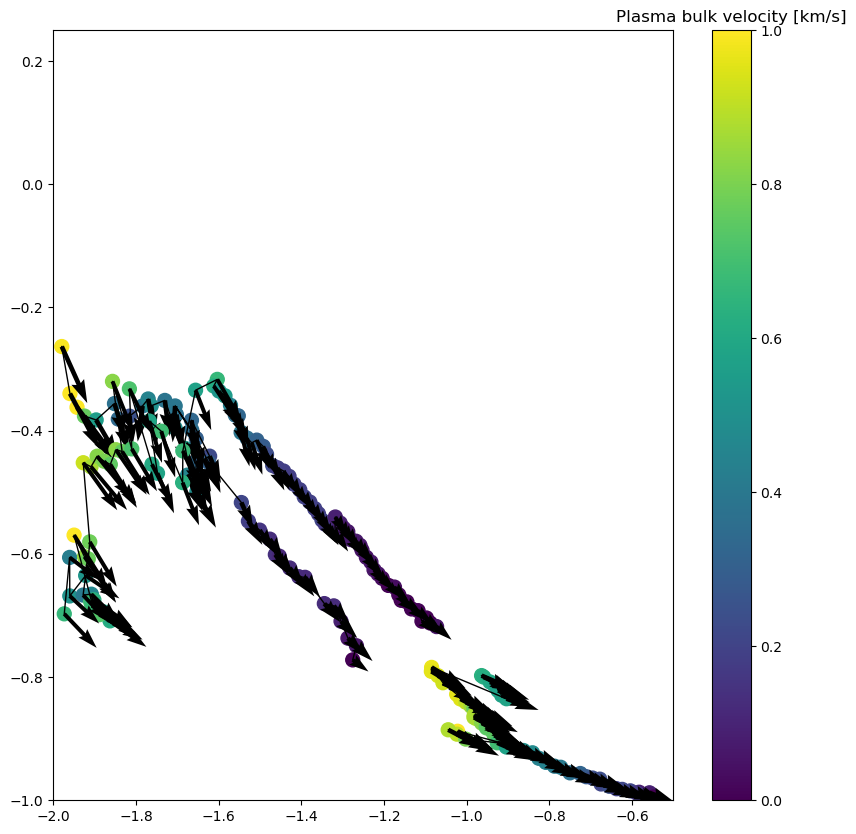

In [6]:
fig,ax = plt.subplots(figsize=(10,10))
for key in data.keys():
    if len(data[key]["time"])>20:
        ax.plot(data[key]["X"],data[key]["Y"], color='black', lw = 1)
        plot = ax.scatter(data[key]["X"],data[key]["Y"],s=100,c = np.sqrt(data[key]["ux"]**2+data[key]["uy"]**2))
        plot = ax.quiver(data[key]["X"],data[key]["Y"],data[key]["ux"],data[key]["uy"])
        #s = 500*data[key]["area"],
ax.set_ylim(-1,0.25)
ax.set_xlim(-2,-0.5)
clb = fig.colorbar(plot, ax=ax)#,norm=LogNorm())  
clb.ax.set_title('Plasma bulk velocity [km/s]',fontsize=12)

In [8]:
# write 
#geeky_file = open('dfs_v2r2at2', 'wb') 
#pickle.dump(avg_dict, geeky_file) 

#geeky_file = open('df_history_v3r1t3', 'wb') 
#pickle.dump(data, geeky_file) 
#geeky_file.close() 

In [54]:
# read
with open('df_history_v3r1t3', 'rb') as f:
    data = pickle.load(f) #avg_dict

Text(0.5, 1.0, 'DF average $\\Delta B_z$ [nT]')

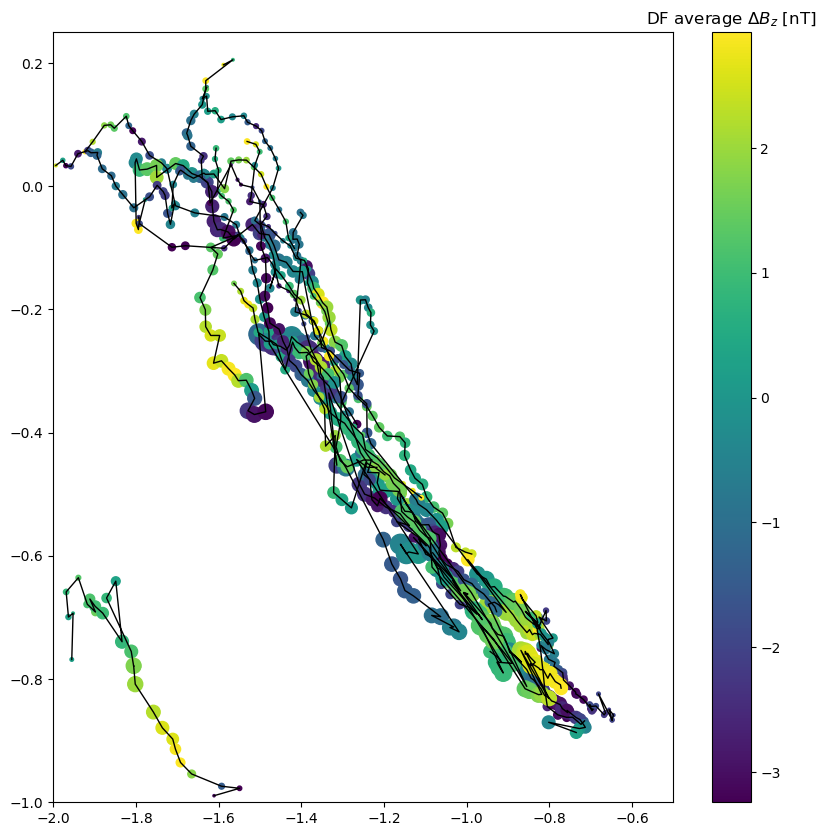

In [34]:
fig,ax = plt.subplots(figsize=(10,10))
for key in data.keys():
    if len(data[key]["time"])>20:
        ax.plot(data[key]["X"],data[key]["Y"], color='black', lw = 1)
        plot = ax.scatter(data[key]["X"],data[key]["Y"],s=1e3*data[key]["area"],c = data[key]["Bz"])#,vmin=0,vmax=1000)
        #s = 500*data[key]["area"],
ax.set_ylim(-1,0.25)
ax.set_xlim(-2,-0.5)
clb = fig.colorbar(plot, ax=ax)#,norm=LogNorm())  
clb.ax.set_title('DF average $\Delta B_z$ [nT]',fontsize=12)

Text(0, 0.5, 'Distance [km]')

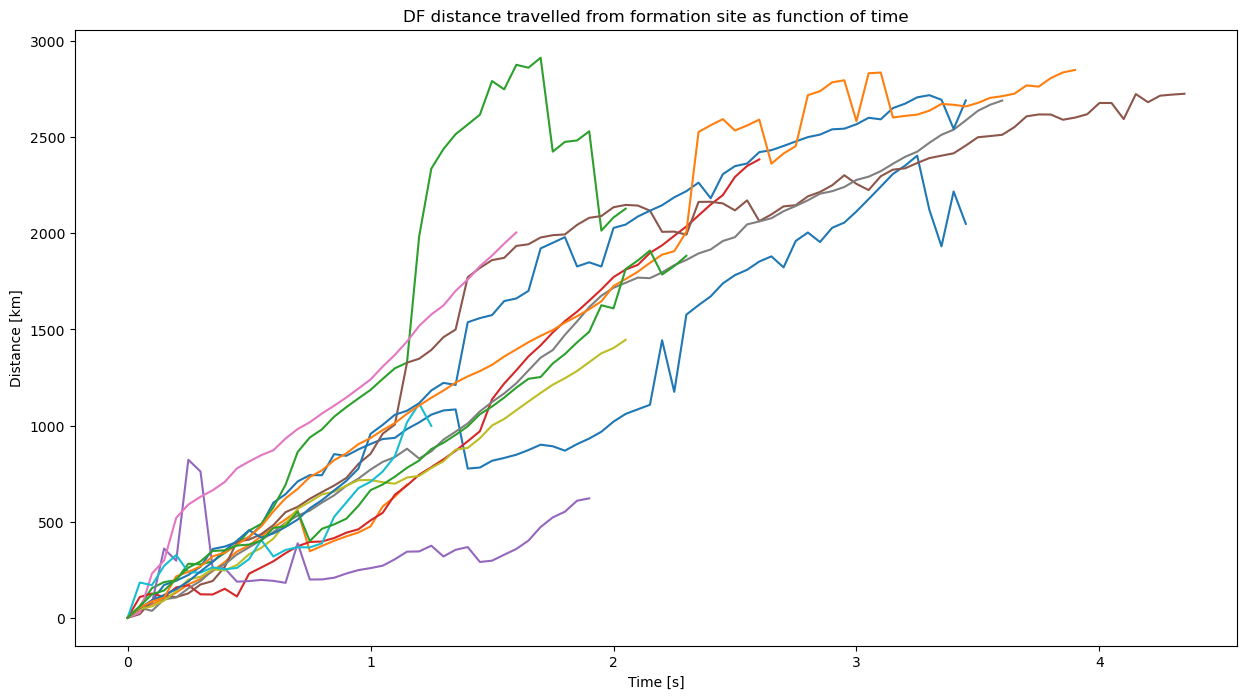

In [52]:
fig,ax = plt.subplots(figsize=(15,8))
for key in data.keys():
    if len(data[key]["time"])>20:
        plot = ax.plot(data[key]["time"]-data[key]["time"][0],(np.sqrt((data[key]["X"]-data[key]["X"][0])**2+(data[key]["Y"]-data[key]["Y"][0])**2))*R_M*1e-3)#,vmin=0,vmax=1000)
        #s = 500*data[key]["area"],
ax.set_title("DF distance travelled from formation site as function of time")
ax.set_xlabel("Time [s]")
ax.set_ylabel("Distance [km]")
#ax.set_xscale("log")
#ax.set_yscale("log")

Text(0, 0.5, 'Bulk flow [km/s]')

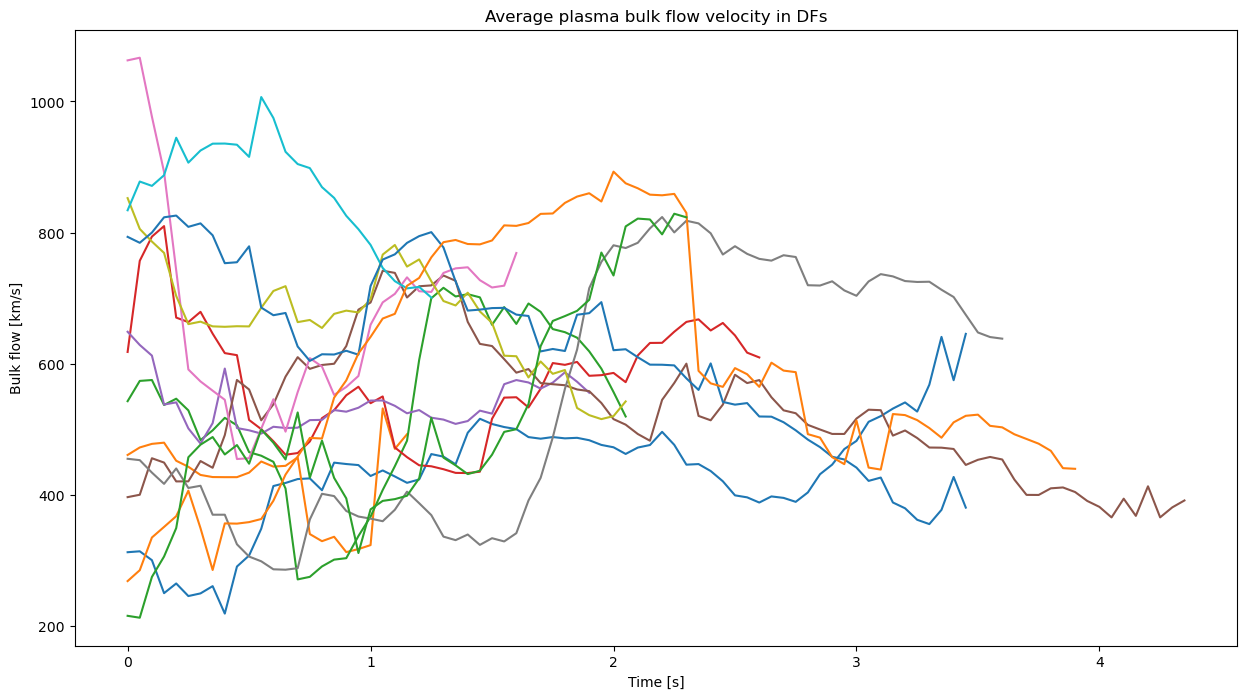

In [51]:
fig,ax = plt.subplots(figsize=(15,8))
for key in data.keys():
    if len(data[key]["time"])>20:
        plot = ax.plot(data[key]["time"]-data[key]["time"][0],np.sqrt(data[key]['ux']**2+data[key]['uy']**2))#,vmin=0,vmax=1000)
        #s = 500*data[key]["area"],
ax.set_title("Average plasma bulk flow velocity in DFs")
ax.set_xlabel("Time [s]")
ax.set_ylabel("Bulk flow [km/s]")
#ax.set_xscale("log")
#ax.set_yscale("log")

In [ ]:
# LINEPLOT ANALYSIS V1
# run a the preset "along_line", then run the two cells below to plot time average subtracted data

In [21]:
x1=np.array((0,2,3,4))
x2=np.array((3,4,5,6))
xmask = np.isin(x1,x2)

y1=np.array((0,0,1,0))
y2=np.array((1,2,2,2))
ymask = np.isin(y1,y2)

mask=xmask&ymask

In [22]:
mask

array([False, False,  True, False])

In [7]:
if mask.any():
    print("TRUE")

TRUE


In [27]:
# After saving "data", we can now plot average-subtracted data
data_avg, data_std = average_data(data)

In [30]:
# Averaged data plotting tools
#var_ls = ["Bz1","uxS1","uxS0","p_ion","Te"]
plot_along_line_avg(data,data_avg,data_std)

Plotting time 10.0
Plotting time 10.05
Plotting time 10.1
Plotting time 10.15
Plotting time 10.2
Plotting time 10.25
Plotting time 10.3
Plotting time 10.35
Plotting time 10.4
Plotting time 10.45
Plotting time 10.5
Plotting time 10.55
Plotting time 10.6
Plotting time 10.65
Plotting time 10.7
Plotting time 10.75
Plotting time 10.8
Plotting time 10.85
Plotting time 10.9
Plotting time 10.95
Plotting time 11.0
Plotting time 11.05
Plotting time 11.1
Plotting time 11.15
Plotting time 11.2
Plotting time 11.25
Plotting time 11.3
Plotting time 11.35
Plotting time 11.4
Plotting time 11.45
Plotting time 11.5
Plotting time 11.55
Plotting time 11.6
Plotting time 11.65
Plotting time 11.7
Plotting time 11.75
Plotting time 11.8
Plotting time 11.85
Plotting time 11.9
Plotting time 11.95
Plotting time 12.0
Plotting time 12.05
Plotting time 12.1
Plotting time 12.15
Plotting time 12.2
Plotting time 12.25
Plotting time 12.3
Plotting time 12.35
Plotting time 12.4
Plotting time 12.45
Plotting time 12.5
Plotti

### Separate Analysis Section

In [5]:
# LINEPLOT ANALYSIS V2
# This analysis averages over multiple parallel line traces

#################################################### USER INPUT START ####################################################

dir = "/Users/atcushen/Documents/MercuryModelling/runs/nightside_v2_run1/ta-3/"    # Directory with data 
start_time = 17                                                # What is the start time of the dataset?
t_bound = [17,33]                                               # Start and stop times for the GIF
dt = 0.05                                                     # What is the timestep between files?
var_ls = ["Bz1","uxS1","uxS0","Ti","Te"]#,"uxS0","p_ion","Te","ram","-grad(p)","-grad(B^2)"]

#################################################### USER INPUT END ####################################################

# Iterate through each file
files = get_files(dir,key="3d\_fluid.*\.plt")
all_avg = {}
all_std = {}
for time in list(files.keys()): 
    print("Loading t =",time)
    file = str(files[time])

    # Extract Current Surface
    data = extract_current_surface(dir+file,var_ls=var_ls)

    # Line settings
    num_points = 200 # Number of points for each line
    line_start = [-2,0] # Coordinates of start
    line_end = [-0.6,-1] # Coordinates of end
    line_width = 0.02 # y extent of line
    num_lines = 15 # How many lines to trace across y (min 2)

    # Extract each line, from y0-width/2 to y0+width/2
    line_ls = []
    for i in range(num_lines):
        line_ls.append(extract_line(data,list(map(add, line_start, [0,-line_width/2 + line_width/(num_lines-1)*i])),list(map(add, line_end, [0,-line_width/2 + line_width/(num_lines-1)*i]))))

    # Combine lines into an avg. and std. array
    line_avg = {}
    line_std = {}
    for var in list(data.keys()):
        print("Computing line averages for",var)
        # Unpack line_ls into an array for just this var
        line_array = np.zeros((num_points,num_lines))
        for i in range(num_lines):
            line_array[:,i] = line_ls[i][var]
        line_avg[var] = np.mean(line_array, axis=1)
        line_std[var] = np.std(line_array, axis=1)

    # Save line_avg and line_std to the record
    all_avg[time] = line_avg
    all_std[time] = line_std

# After looping through all, we can compute the time-averaged value at each point in line for each var
time_avg = {}
for var in list(data.keys()):
    # Declare empty array to gather data into
    temp = np.zeros((num_points))
    # Add data to this array from each timestep
    for time in list(files.keys()):
        temp += all_avg[time][var]
    # Save average
    time_avg[var] = temp/len(list(files.keys()))


Loading t = 17.0
reading: /Users/atcushen/Documents/MercuryModelling/runs/nightside_v2_run1/ta-3/3d_fluid_region0_0_t00000017_n00011900_amrex.plt
Connecting to Tecplot 360 TecUtil Server on:
    tcp://localhost:7600
Connection established.
Beginning interpolation...


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_23226/104802889.py:186: RuntimeWarning: invalid value encountered in divide
  beta_meshgrid = (2*mu_0*(rect_zone.values("pxxS0").as_numpy_array()+rect_zone.values("pyyS0").as_numpy_array()+rect_zone.values("pzzS0").as_numpy_array()+rect_zone.values("pxxS1").as_numpy_array()+


Interpolation complete, searching for max beta and saving data
Extracting Z
Extracting Bz1
Extracting uxS1
Extracting uxS0
Extracting Ti


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_23226/104802889.py:208: RuntimeWarning: invalid value encountered in divide
  var = ((rect_zone.values("pxxS1").as_numpy_array()+rect_zone.values("pyyS1").as_numpy_array()+
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_23226/104802889.py:211: RuntimeWarning: invalid value encountered in divide
  var = ((rect_zone.values("pxxS0").as_numpy_array()+rect_zone.values("pyyS0").as_numpy_array()+


Extracting Te
Complete!
Computing line averages for X
Computing line averages for Y
Computing line averages for Z
Computing line averages for Bz1
Computing line averages for uxS1
Computing line averages for uxS0
Computing line averages for Ti
Computing line averages for Te
Loading t = 17.05
reading: /Users/atcushen/Documents/MercuryModelling/runs/nightside_v2_run1/ta-3/3d_fluid_region0_0_t00000017_n00011927_amrex.plt
Connecting to Tecplot 360 TecUtil Server on:
    tcp://localhost:7600
Connection established.
Beginning interpolation...
Interpolation complete, searching for max beta and saving data
Extracting Z
Extracting Bz1
Extracting uxS1
Extracting uxS0
Extracting Ti
Extracting Te
Complete!
Computing line averages for X
Computing line averages for Y
Computing line averages for Z
Computing line averages for Bz1
Computing line averages for uxS1
Computing line averages for uxS0
Computing line averages for Ti
Computing line averages for Te
Loading t = 17.1
reading: /Users/atcushen/Docum

In [8]:
 # Now, loop through all the times and save plots of val - avg
for time in list(all_avg.keys()):
    print("Plotting time",time)

    if 'ram' in var_ls:
        nrows = len(var_ls)-2
    else:
        nrows = len(var_ls)

    # Plot the results
    line = all_avg[time]
    line["s"] = np.sqrt((line["X"]-line["X"][0])**2+(line["Y"]-line["Y"][0])**2)
    fig, axs = plt.subplots(ncols=1,nrows=nrows,figsize=(16,4*nrows))

     # Pressure balance plot
    if 'ram' in var_ls:
        axs[-1].plot(line["s"]*R_M/1e3,line['ram']-time_avg['ram'],label='ram',color='red')
        axs[-1].plot(line["s"]*R_M/1e3,line['-grad(p)']-time_avg['-grad(p)'],label='-grad(p)',color='green')
        axs[-1].plot(line["s"]*R_M/1e3,line['-grad(B^2)']-time_avg['-grad(B^2)'],label='-grad(B^2)',color='blue')
        #axs[-1].plot(line["s"]*R_M/1e3,line['ram']+line['-grad(p)']+line['-grad(B^2)'],color="black",label="total")
        axs[-1].set_ylabel(str("Perturbation force density [N/m$^3$]"))
        axs[-1].legend(loc = "upper left")
        axs[-1].set_ylim(-1e-13,1e-13)
        axs[-1].set_xlabel("Path length [km]")


    # Step through each subplot
    for i in range(nrows):

        if (var_ls[i] == 'ram') or (var_ls[i] == '-grad(p)') or (var_ls[i] == '-grad(B^2)'):
            continue

        axs[i].plot(line["s"]*R_M/1e3,line[var_ls[i]]-time_avg[var_ls[i]],color="black",label=var_ls[i])
        axs[i].fill_between(line["s"]*R_M/1e3,line[var_ls[i]]-time_avg[var_ls[i]]-all_std[time][var_ls[i]],line[var_ls[i]]-time_avg[var_ls[i]]+all_std[time][var_ls[i]],color="red",alpha=0.3)
        
        # Magnetic field plotting
        if (var_ls[i] == "Bx") or (var_ls[i] == "By") or (var_ls[i] == "Bz"):
            axs[i].set_ylabel(str("$B_"+str(var_ls[i][-1])+"$ [nT]"))
            if var_ls[i] == "Bz":
                axs[i].plot(line["s"]*R_M/1e3,Bz_dip(line["X"],line["Y"],line["Z"]),color="black",linestyle="dashed",alpha = 0.8,label="Dipole")
                axs[i].legend(loc="lower right")
                
        # Perturbation field plotting
        elif (var_ls[i] == "Bz1"):
            axs[i].set_ylabel(str("Δ$B_z$ [nT]"))
            axs[i].set_ylim(-30,30)
        
        # Pressure plotting
        elif (var_ls[i] == "p_ion") or (var_ls[i] == "p_electron"):
            axs[i].set_ylabel(str("Δ$p_{"+str(var_ls[i][2:])+"}$ [nPa]"))
            axs[i].set_ylim(-1,1)

        # Ion velocity plotting
        elif (var_ls[i] == "uxS1") or (var_ls[i] == "uyS1") or (var_ls[i] == "uzS1"):
            axs[i].set_ylabel(str("Δ$u_{"+str(var_ls[i][1])+",ion}$ [km/s]"))
            axs[i].set_ylim(-600,600)

        # Electron velocity plotting
        elif (var_ls[i] == "uxS0") or (var_ls[i] == "uyS0") or (var_ls[i] == "uzS0"):
            axs[i].set_ylabel(str("Δ$u_{"+str(var_ls[i][1])+",electron}$ [km/s]"))
            axs[i].set_ylim(-4000,4000)

        # Current plotting
        elif (var_ls[i] == "Jx") or (var_ls[i] == "Jy") or (var_ls[i] == "Jz"):
            axs[i].set_ylabel(str("$J_{"+str(var_ls[i][1])+"}$ [μA/m$^2$]"))

        # Temperature plotting
        elif (var_ls[i] == "Te") or (var_ls[i] == "Ti"):
            axs[i].set_ylabel(str("Δ$T_{"+str(var_ls[i][-1])+"}$ [eV]"))
            #axs[i].set_yscale('log')
            axs[i].set_ylim(-4e3,4e3)

        axs[i].set_xlabel("Path length [km]")
        axs[0].set_title(str("Value - time average, averaged across "+str(num_lines)+" lines from "+
                             str(line_start)+" to "+str(line_end)+" with width "+str(line_width)+" at t="+str(round(time,2))+"s"))

    fig.savefig(str(str(dir[:-1])+"_plots/multiline_avg_"+"%.2f"%round(time,2)+'.png'),bbox_inches='tight')
    plt.close(fig)

Plotting time 17.0
Plotting time 17.05
Plotting time 17.1
Plotting time 17.15
Plotting time 17.2
Plotting time 17.25
Plotting time 17.3
Plotting time 17.35
Plotting time 17.4
Plotting time 17.45
Plotting time 17.5
Plotting time 17.55
Plotting time 17.6
Plotting time 17.65
Plotting time 17.7
Plotting time 17.75
Plotting time 17.8
Plotting time 17.85
Plotting time 17.9
Plotting time 17.95
Plotting time 18.0
Plotting time 18.05
Plotting time 18.1
Plotting time 18.15
Plotting time 18.2
Plotting time 18.25
Plotting time 18.3
Plotting time 18.35
Plotting time 18.4
Plotting time 18.45
Plotting time 18.5
Plotting time 18.55
Plotting time 18.6
Plotting time 18.65
Plotting time 18.7
Plotting time 18.75
Plotting time 18.8
Plotting time 18.85
Plotting time 18.9
Plotting time 18.95
Plotting time 19.0
Plotting time 19.05
Plotting time 19.1
Plotting time 19.15
Plotting time 19.2
Plotting time 19.25
Plotting time 19.3
Plotting time 19.35
Plotting time 19.4
Plotting time 19.45
Plotting time 19.5
Plotti

In [9]:
 # Overlay Bz, u_ion, Te
for time in list(all_avg.keys()):
    print("Plotting time",time)

    # Plot the results
    line = all_avg[time]
    line["s"] = np.sqrt((line["X"]-line["X"][0])**2+(line["Y"]-line["Y"][0])**2)
    fig, ax = plt.subplots(ncols=1,nrows=1,figsize=(16,4))

    # Step through each subplot
    # B_z
    ax.plot(line["s"]*R_M/1e3,line["Bz1"]-time_avg["Bz1"],color="black")
    ax.fill_between(line["s"]*R_M/1e3,line["Bz1"]-time_avg["Bz1"]-all_std[time]["Bz1"],line["Bz1"]-time_avg["Bz1"]+all_std[time]["Bz1"],color="black",alpha=0.2)
    ax.set_ylim(-30,30)
    ax.set_ylabel("Δ$B_z$ [nT]")

    # U_x,ion
    ax2 = ax.twinx()
    ax2.plot(line["s"]*R_M/1e3,line["uxS1"]-time_avg["uxS1"],color="red")
    ax2.fill_between(line["s"]*R_M/1e3,line["uxS1"]-time_avg["uxS1"]-all_std[time]["uxS1"],line["uxS1"]-time_avg["uxS1"]+all_std[time]["uxS1"],color="red",alpha=0.2)
    ax2.set_ylim(-700,700)
    ax2.yaxis.label.set_color("red")
    ax2.spines["right"].set_edgecolor('red')
    ax2.tick_params(axis='y', colors='red')
    ax2.set_ylabel("Δ$u_{x,ion}$ [km/s]")

     # Te
    ax3 = ax.twinx()
    ax3.spines["right"].set_position(("axes", 1.08))
    ax3.plot(line["s"]*R_M/1e3,(line["Te"]-time_avg["Te"])/1e3,color="blue")
    ax3.fill_between(line["s"]*R_M/1e3,(line["Te"]-time_avg["Te"]-all_std[time]["Te"])/1e3,(line["Te"]-time_avg["Te"]+all_std[time]["Te"])/1e3,color="blue",alpha=0.2)
    ax3.set_ylim(-4,4)
    ax3.yaxis.label.set_color("blue")
    ax3.spines["right"].set_edgecolor('blue')
    ax3.tick_params(axis='y', colors='blue')
    ax3.set_ylabel("Δ$T_{e}$ [keV]")
    
    ax.set_xlabel("Path length [km]")
    ax.set_title(str("Value - time average, averaged across "+str(num_lines)+" lines from "+
                             str(line_start)+" to "+str(line_end)+" with width "+str(line_width)+" at t=%.2f"%round(time,2)+"s"))

    fig.savefig(str(str(dir[:-1])+"_plots/multiline_overlay_"+"%.2f"%round(time,2)+'.png'),bbox_inches='tight')
    plt.close(fig)

Plotting time 17.0
Plotting time 17.05
Plotting time 17.1
Plotting time 17.15
Plotting time 17.2
Plotting time 17.25
Plotting time 17.3
Plotting time 17.35
Plotting time 17.4
Plotting time 17.45
Plotting time 17.5
Plotting time 17.55
Plotting time 17.6
Plotting time 17.65
Plotting time 17.7
Plotting time 17.75
Plotting time 17.8
Plotting time 17.85
Plotting time 17.9
Plotting time 17.95
Plotting time 18.0
Plotting time 18.05
Plotting time 18.1
Plotting time 18.15
Plotting time 18.2
Plotting time 18.25
Plotting time 18.3
Plotting time 18.35
Plotting time 18.4
Plotting time 18.45
Plotting time 18.5
Plotting time 18.55
Plotting time 18.6
Plotting time 18.65
Plotting time 18.7
Plotting time 18.75
Plotting time 18.8
Plotting time 18.85
Plotting time 18.9
Plotting time 18.95
Plotting time 19.0
Plotting time 19.05
Plotting time 19.1
Plotting time 19.15
Plotting time 19.2
Plotting time 19.25
Plotting time 19.3
Plotting time 19.35
Plotting time 19.4
Plotting time 19.45
Plotting time 19.5
Plotti

In [24]:
var_ls

['Bz1', 'uxS1', 'uxS0', 'Ti', 'Te']

In [21]:
 # Alternatively, loop through all the times and save plots of val/avg
for time in list(all_avg.keys()):
    print("Plotting time",time)

    if 'ram' in var_ls:
        nrows = len(var_ls)-2
    else:
        nrows = len(var_ls)

    # Plot the results
    line = all_avg[time]
    line["s"] = np.sqrt((line["X"]-line["X"][0])**2+(line["Y"]-line["Y"][0])**2)
    fig, axs = plt.subplots(ncols=1,nrows=nrows,figsize=(16,4*nrows))

     # Pressure balance plot
    if 'ram' in var_ls:
        axs[-1].plot(line["s"]*R_M/1e3,line['ram']-time_avg['ram'],label='ram',color='red')
        axs[-1].plot(line["s"]*R_M/1e3,line['-grad(p)']-time_avg['-grad(p)'],label='-grad(p)',color='green')
        axs[-1].plot(line["s"]*R_M/1e3,line['-grad(B^2)']-time_avg['-grad(B^2)'],label='-grad(B^2)',color='blue')
        #axs[-1].plot(line["s"]*R_M/1e3,line['ram']+line['-grad(p)']+line['-grad(B^2)'],color="black",label="total")
        axs[-1].set_ylabel(str("Perturbation force density [N/m$^3$]"))
        axs[-1].legend(loc = "upper left")
        axs[-1].set_ylim(-1e-13,1e-13)
        axs[-1].set_xlabel("Path length [km]")


    # Step through each subplot
    for i in range(nrows):

        if (var_ls[i] == 'ram') or (var_ls[i] == '-grad(p)') or (var_ls[i] == '-grad(B^2)'):
            continue

        axs[i].plot(line["s"]*R_M/1e3,np.abs(line[var_ls[i]]/time_avg[var_ls[i]]),color="black",label=var_ls[i])
        #axs[i].fill_between(line["s"]*R_M/1e3,(1-all_std[time][var_ls[i]])/time_avg[var_ls[i]],(1+all_std[time][var_ls[i]])/time_avg[var_ls[i]],color="red",alpha=0.3)
        axs[i].set_ylim(0,5)
        
        # Magnetic field plotting
        if (var_ls[i] == "Bx") or (var_ls[i] == "By") or (var_ls[i] == "Bz"):
            axs[i].set_ylabel(str("$B_"+str(var_ls[i][-1])+"$ [nT]"))
            if var_ls[i] == "Bz":
                axs[i].plot(line["s"]*R_M/1e3,Bz_dip(line["X"],line["Y"],line["Z"]),color="black",linestyle="dashed",alpha = 0.8,label="Dipole")
                axs[i].legend(loc="lower right")
                
        # Perturbation field plotting
        elif (var_ls[i] == "Bz1"):
            axs[i].set_ylabel(str("Δ$B_z$"))
        
        # Pressure plotting
        elif (var_ls[i] == "p_ion") or (var_ls[i] == "p_electron"):
            axs[i].set_ylabel(str("Δ$p_{"+str(var_ls[i][2:])+"}$ "))

        # Ion velocity plotting
        elif (var_ls[i] == "uxS1") or (var_ls[i] == "uyS1") or (var_ls[i] == "uzS1"):
            axs[i].set_ylabel(str("Δ$u_{"+str(var_ls[i][1])+",ion}$"))

        # Electron velocity plotting
        elif (var_ls[i] == "uxS0") or (var_ls[i] == "uyS0") or (var_ls[i] == "uzS0"):
            axs[i].set_ylabel(str("Δ$u_{"+str(var_ls[i][1])+",electron}$"))

        # Current plotting
        elif (var_ls[i] == "Jx") or (var_ls[i] == "Jy") or (var_ls[i] == "Jz"):
            axs[i].set_ylabel(str("$J_{"+str(var_ls[i][1])+"}$"))

        # Temperature plotting
        elif (var_ls[i] == "Te") or (var_ls[i] == "Ti"):
            axs[i].set_ylabel(str("Δ$T_{"+str(var_ls[i][-1])+"}$"))

        axs[i].set_xlabel("Path length [km]")
        axs[0].set_title(str("Normalized values, averaged across "+str(num_lines)+" lines from "+
                             str(line_start)+" to "+str(line_end)+" with width "+str(line_width)+" at t="+str(round(time,2))+"s"))

    fig.savefig(str(str(dir[:-1])+"_plots/multiline_normalized_"+"%.2f"%round(time,2)+'.png'),bbox_inches='tight')
    plt.close(fig)

Plotting time 10.0
Plotting time 10.05
Plotting time 10.1
Plotting time 10.15
Plotting time 10.2
Plotting time 10.25
Plotting time 10.3
Plotting time 10.35
Plotting time 10.4
Plotting time 10.45
Plotting time 10.5
Plotting time 10.55
Plotting time 10.6
Plotting time 10.65
Plotting time 10.7
Plotting time 10.75
Plotting time 10.8
Plotting time 10.85
Plotting time 10.9
Plotting time 10.95
Plotting time 11.0
Plotting time 11.05
Plotting time 11.1
Plotting time 11.15
Plotting time 11.2
Plotting time 11.25
Plotting time 11.3
Plotting time 11.35
Plotting time 11.4
Plotting time 11.45
Plotting time 11.5
Plotting time 11.55
Plotting time 11.6
Plotting time 11.65
Plotting time 11.7
Plotting time 11.75
Plotting time 11.8
Plotting time 11.85
Plotting time 11.9
Plotting time 11.95
Plotting time 12.0
Plotting time 12.05
Plotting time 12.1
Plotting time 12.15
Plotting time 12.2
Plotting time 12.25
Plotting time 12.3
Plotting time 12.35
Plotting time 12.4
Plotting time 12.45
Plotting time 12.5
Plotti

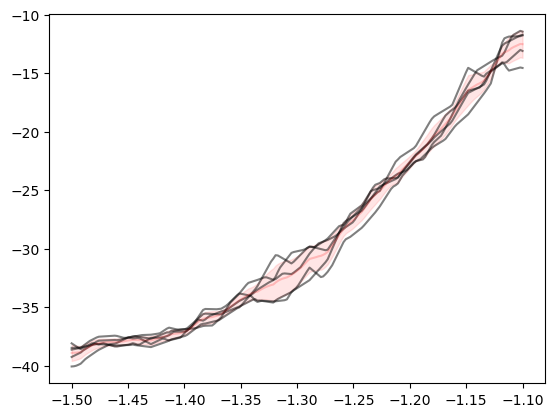

In [37]:
for i in range(num_lines):
    plt.plot(line_ls[i]["X"],line_ls[i]["Bz1"], color="black",alpha=0.5)
plt.plot(line_avg["X"],line_avg["Bz1"],color='red',alpha=0.2)
plt.fill_between(line_avg["X"],line_avg["Bz1"]-line_std["Bz1"],line_avg["Bz1"]+line_std["Bz1"],color='red',alpha=0.1)

In [27]:
dc = {1:"a",2:"b"}

In [31]:
np.max(list(dc.keys()))

2

In [ ]:
print(hi)